# **Job Postings Clustering based on skills**

This is a second part pf Job Recomendation System based on clustering prohject. Within this part I create The table for clustering, cluster job postings and choose the best one which is going to be used for the supervised learning part

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import openpyxl
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import pairwise_distances
import warnings
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import plot_tree
from matplotlib.colors import ListedColormap
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
from scipy.stats import kurtosis
import re
from sentence_transformers import SentenceTransformer, util
from wordcloud import WordCloud
from collections import Counter
from math import pi
import sklearn.metrics







# Setting up max display in notebook 
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
warnings.filterwarnings('ignore')

***

# Creating Master Tabel and grouping skills

Arter the EDA of the whole set its time to prepare a dataset that will be used during clustering and classification. For this purpouse we have to start with grouping skills into more overall categories. In this project we chose following categories of skills:

* soft skills
* leadership skills
* design_art skills
* programming skills
* data science skills
* medical skills
* engeneering skills
* craftmanships skills
* financial skills
* operational logistics skills
* marketing skills

For each category we collected the most representative keywords (in our opinion) and asked Launguage model Geminai to expand the list. Then we used **semantic search approach** utilizing the **Sentence BERT (SBERT)** architecture. Specifically, we used the all-MiniLM-L6-v2 model to generate dense vector embeddings for both the scraped skills and a predefined taxonomy. Therfore skills were put into groups based on cosine distance from the collected key words (exceeding threshold > 0.5). All of the skills that did nt meet this expectation were put in category "diffrent". Within this category are mostly things related to employess benefit and work demands like 40h per week/elastic time schedule ect. Additionaly to avoid unnessesery word there is a black listed word list whcich contains wors that do not match what a skills is:

**blacklist_words** = 
    'experience', 'qualification', 'certificate', 'diploma',
    'master', 'bachelor', 'degree', 'field', 'relevant',
    'knowledge', 'week', 'year', 'years', 'month', 'months', 'hours', 'hour',
    'minute', 'minutes', 'language', 'english', 'spanish', 'french', 'german', 
    'italian', 'high school diploma', 'phd', 'ph.d', 'certified', 'certification',
    'competetive salary', 'holiday', 'school', 'research', 'bachelor degree'

This approach is definitly too trival for this dataset - the skills column is still not clean enought since there are not only skills but many more job descroiption, which is fault of web scrapping. Also the semantic search approach does not indetify all of the skills corretly - there are a lot of wrongly assigned skills, but still its better then nothing

***

In this part I also decides to continue with only one countries data - United Kingdom's data. It was decided like that beacuse all of the countries seems to have their own patterns in job postings so dataset for one coutry will be more coherent. Additionaly it will significantly reduce number of skills we need to process - unfortunetly with USA data the Jupyter Notebook did not have a chance. Wjile trying to group over 2 milions of unique skills - the visual studio code on my computer shut down three times. After that I gave up and moved to UK's dataset.


**Grouping skills with NLP toolkit**

In [2]:
df_categories = pd.read_excel('C:/Users/olgas/OneDrive/Pulpit/skills.xlsx')

df_scraped = pd.read_csv('C:/Users/olgas/OneDrive/Documents/GitHub/Job-project/uk_jobs_deduped_skills.csv')
df_scraped.dropna(inplace=True)

blacklist_words = [
    'experience', 'qualification', 'certificate', 'diploma',
    'master', 'bachelor', 'degree', 'field', 'relevant',
    'knowledge', 'week', 'year', 'years', 'month', 'months', 'hours', 'hour',
    'minute', 'minutes', 'language', 'english', 'spanish', 'french', 'german', 
    'italian', 'high school diploma', 'phd', 'ph.d', 'certified', 'certification',
    'competetive salary', 'holiday', 'school', 'research', 'bachelor degree'
]


def new_colums_skills(row):
    
    raw_skills = row['list_deduped_skills'].split(', ')
    
    cleaned_skills = []
    for skill in raw_skills:
        skill_lower = skill.lower().strip()
        
        if len(skill_lower) < 3:
            continue

        if skill_lower in blacklist_words:
            continue
  
        if any(bad_word in skill_lower for bad_word in blacklist_words):

             for bad_word in blacklist_words:
                 skill_lower = skill_lower.replace(bad_word, '').strip()
        
        if len(skill_lower) >= 2:
            cleaned_skills.append(skill_lower)
            
    return cleaned_skills
    

df_scraped['scraped_skill'] = df_scraped.apply(new_colums_skills, axis=1)

df_scraped.head(10)


ÿjob_link  \
0  https://uk.linkedin.com/jobs/view/clinical-the...   
1  https://uk.linkedin.com/jobs/view/production-e...   
2  https://uk.linkedin.com/jobs/view/piping-and-l...   
3  https://uk.linkedin.com/jobs/view/engineering-...   
4  https://uk.linkedin.com/jobs/view/physicians-a...   
5  https://uk.linkedin.com/jobs/view/energy-syste...   
6  https://uk.linkedin.com/jobs/view/digital-infr...   
7  https://uk.linkedin.com/jobs/view/in-house-cri...   
8  https://uk.linkedin.com/jobs/view/service-mana...   
9  https://uk.linkedin.com/jobs/view/cardiac-reha...   

             last_processed_time  \
0  2024-01-19 09:45:09.215838+00   
1  2024-01-19 09:45:09.215838+00   
2  2024-01-19 09:45:09.215838+00   
3  2024-01-20 10:50:29.824282+00   
4  2024-01-19 09:45:09.215838+00   
5  2024-01-20 04:01:14.993088+00   
6  2024-01-21 01:09:53.004121+00   
7  2024-01-19 09:45:09.215838+00   
8  2024-01-19 09:45:09.215838+00   
9  2024-01-19 09:45:09.215838+00   

                                           job_title  \
0                           clinical theatre manager   
1                     production engineering manager   
2                  piping and layout design engineer   
3                          engineering manager (cem)   
4                               physicians associate   
5  energy systems innovation lead - ofgem program...   
6                     digital infrastructure manager   
7  in house critical facility manager / mep hard ...   
8                             service manager - send   
9  cardiac rehabilitation specialist nurse practi...   

                                             company  \
0  university hospitals bristol and weston nhs fo...   
1                                              roxel   
2                                          itm power   
3                                         amcogiffen   
4                                        bmj careers   
5                                        innovate uk   
6                        eynsham partnership academy   
7                                                prs   
8                                      wigan council   
9                      somerset nhs foundation trust   

                                job_location  first_seen   search_city  \
0           bristol, england, united kingdom  13/01/2024       newport   
1     kidderminster, england, united kingdom  13/01/2024     worcester   
2         sheffield, england, united kingdom  12/01/2024     mansfield   
3        warrington, england, united kingdom  15/01/2024     liverpool   
4       stourbridge, england, united kingdom  13/01/2024     worcester   
5  moreton-in-marsh, england, united kingdom  14/01/2024    gloucester   
6                        greater oxford area  16/01/2024        oxford   
7            slough, england, united kingdom  13/01/2024  high wycombe   
8             wigan, england, united kingdom  13/01/2024     liverpool   
9            oxford, england, united kingdom  13/01/2024  high wycombe   

   search_country                         search_position   job_level  \
0  united kingdom                          director stage  mid senior   
1  united kingdom                manager records analysis  mid senior   
2  united kingdom            aeronautical-design engineer   associate   
3  united kingdom                  electrician supervisor  mid senior   
4  united kingdom                           dermatologist  mid senior   
5  united kingdom                        take-up operator  mid senior   
6  united kingdom       supervisor inspection and testing  mid senior   
7  united kingdom                       equipment cleaner  mid senior   
8  united kingdom                          director stage  mid senior   
9  united kingdom  coordinator of rehabilitation services  mid senior   

  job_type                                         job_skills  \
0   onsite  clinical management, leadership, communication...   
1   onsite  production engineering, process fl

In [3]:

print("Dowloading NLP model...")

model = SentenceTransformer('all-MiniLM-L6-v2')

all_skills = [skill for sublist in df_scraped['scraped_skill'] for skill in sublist]

unique_skills = list(set(all_skills)) 

print(f" Number of unique skills: {len(unique_skills)}")

def clean_text(text):
    if not isinstance(text, str): return ""
    text = text.lower()
    pattern = r'\b(?:' + '|'.join([re.escape(w) for w in blacklist_words]) + r')\b'
    text = re.sub(pattern, '', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    return re.sub(r'\s+', ' ', text).strip()


clean_unique_skills = [clean_text(s) for s in unique_skills]
df_categories['clean_keyword'] = df_categories['skill_keyword'].apply(clean_text)

print("Creting embeddings...")

scraped_embeddings = model.encode(clean_unique_skills, convert_to_tensor=True, show_progress_bar=True)

category_embeddings = model.encode(df_categories['clean_keyword'].tolist(), convert_to_tensor=True)

print("Matching...")
hits = util.semantic_search(scraped_embeddings, category_embeddings, top_k=1)

THRESHOLD = 0.5
skill_to_cluster_map = {}

for i, hit in enumerate(hits):
    original_skill_name = unique_skills[i] 
    
    if hit and hit[0]['score'] >= THRESHOLD:
        match_idx = hit[0]['corpus_id']
        category_name = df_categories.iloc[match_idx]['category']
        
        skill_to_cluster_map[original_skill_name] = category_name
    else:
        skill_to_cluster_map[original_skill_name] = 'diffrent'


def map_skills_to_clusters(skill_list):
    
    return [skill_to_cluster_map.get(skill, 'diffrent') for skill in skill_list]

df_scraped['cluster_results'] = df_scraped['scraped_skill'].apply(map_skills_to_clusters)

print("Results of grouping:")

print(df_scraped[['scraped_skill', 'cluster_results']].head(10))

Dowloading NLP model...
 Number of unique skills: 126465
Creting embeddings...


Batches:   0%|          | 0/3953 [00:00<?, ?it/s]

Matching...
Results of grouping:
                                       scraped_skill  \
0  [policy development, interpersonal, remote wor...   
1  [downtime, engineering management, kaizen, bud...   
2  [piping and bulk material take offs, material ...   
3  [ongoing, mechanical, event, west reward, remi...   
4  [multidisciplinary team, compassion, physician...   
5  [technology support, contending priority, posi...   
6  [esafety investigation, computer system, serve...   
7  [electrical engineering, performance audit, el...   
8  [policy development, interpersonal, attention ...   
9  [audit, policy development, holistic care, com...   

                                     cluster_results  
0  [leadership_skills, soft_skills, leadership_sk...  
1  [diffrent, engineering_skills, operations_logi...  
2  [operations_logistics_skills, operations_logis...  
3  [diffrent, engineering_skills, marketing_sales...  
4  [leadership_skills, soft_skills, medicine_skil...  
5  [engineering_skil

In [4]:
df_exploded = df_scraped[['ÿjob_link', 'cluster_results']].explode('cluster_results')

df_matrix = pd.crosstab(df_exploded['ÿjob_link'], df_exploded['cluster_results'])

df_matrix = df_matrix.reset_index()

df_matrix.columns.name = None

print("Size:", df_matrix.shape)
df_matrix.head()

Size: (19985, 13)


ÿjob_link  craftsmanship_skills  \
0  https://hk.linkedin.com/jobs/view/digital-chie...                     1   
1  https://ng.linkedin.com/jobs/view/client-servi...                     0   
2  https://uk.linkedin.com/jobs/view/%ce%bf-%ce%b...                     7   
3  https://uk.linkedin.com/jobs/view/%ce%bf-%ce%b...                     3   
4  https://uk.linkedin.com/jobs/view/%ce%bf-%ce%b...                     4   

   data_science_skills  design_art_skills  diffrent  engineering_skills  \
0                    0                  3         5                   0   
1                    0                  0        11                   0   
2                    0                  0        15                   4   
3                    0                  0        11                   3   
4                    0                  0        20                   3   

   finance_accounting_skills  leadership_skills  marketing_sales_skills  \
0                          0                  0                      11   
1                          0                  3                       1   
2                          2                  1                       0   
3                          1                  0                       0   
4                          1                  0                       0   

   medicine_skills  operations_logistics_skills  programming_skills  \
0                0                            1                   1   
1                0                            2                   2   
2                3                            2                   2   
3                2                            1                   2   
4                3                            2                   4   

   soft_skills  
0            3  
1            8  
2            2  
3            2  
4            4

***


**Amount of skills in each group**

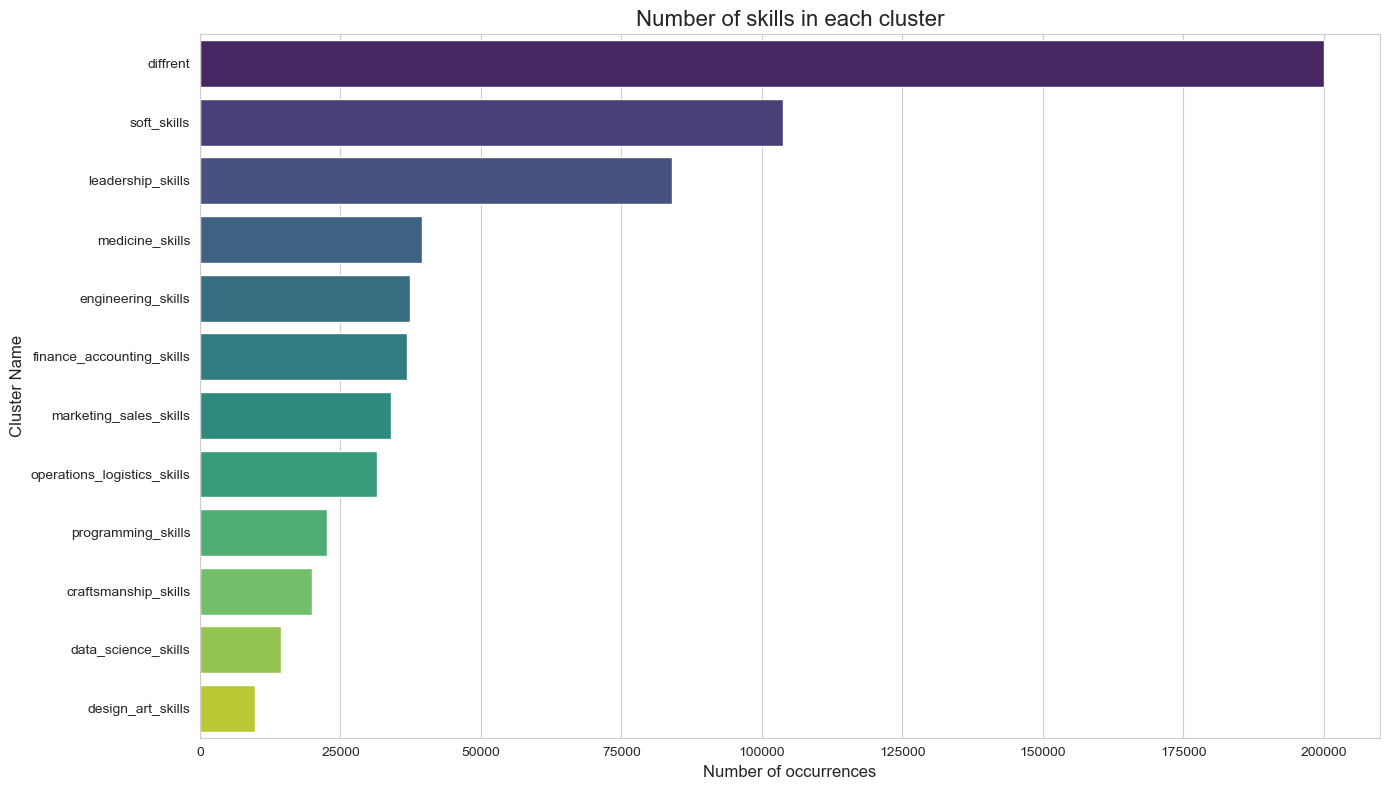

In [5]:


flat_data = []

for skills_list, clusters_list in zip(df_scraped['scraped_skill'], df_scraped['cluster_results']):
    for skill, cluster in zip(skills_list, clusters_list):
        flat_data.append({'Skill': skill, 'Cluster': cluster})

df_viz = pd.DataFrame(flat_data)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

plt.figure(figsize=(14, 8))

cluster_counts = df_viz['Cluster'].value_counts()

sns.barplot(x=cluster_counts.values, y=cluster_counts.index, palette="viridis")

plt.title('Number of skills in each cluster', fontsize=16)
plt.xlabel('Number of occurrences', fontsize=12)
plt.ylabel('Cluster Name', fontsize=12)
plt.tight_layout()
plt.show()

We can see that a lot of the skills does not match any of the of the category so they end up as 'diffrent'. Its results of restrictive threshold 50%, but I stand with my choice - the skills column is extreamly dirty and this was also a part of cleaning it from usless words scrapped as skills.

The top leading groups of skills are no suprise - it was said befor that software skills and medicine skills are mostly wanted in the USA. Design Art category is in my opnion pourly creted when it comes to key words but I did not have any other ideas for now for it. Also, for the record, I was trying many more groups of skills (legal_skills or gastronomy_skills), but the key word matching worked extreamly poorly on them thats why we are left with those 11 groups for now. 

In [6]:
df_viz[df_viz['Cluster'] == 'diffrent']

Skill   Cluster
7                          selfcare  diffrent
16                    documentation  diffrent
18                  professionalism  diffrent
38                       evaluation  diffrent
42      safe and effective practice  diffrent
...                             ...       ...
633835             good reject note  diffrent
633836       dimensional inspection  diffrent
633837       work traveller booking  diffrent
633838                 thread gauge  diffrent
633839                 ferritescope  diffrent

[200027 rows x 2 columns]

Fell free to check out the column with skills in group diffrent. This column will be deleted from the dataset druginh next parts

***



**WordClouds for groups**

In [7]:
def plot_wordcloud(target_cluster):
   
    text_data = df_viz[df_viz['Cluster'] == target_cluster]['Skill']
    
    text = " ".join(text_data.astype(str))

    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='plasma').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Wordcloud for: {target_cluster}', fontsize=15)
    plt.show()

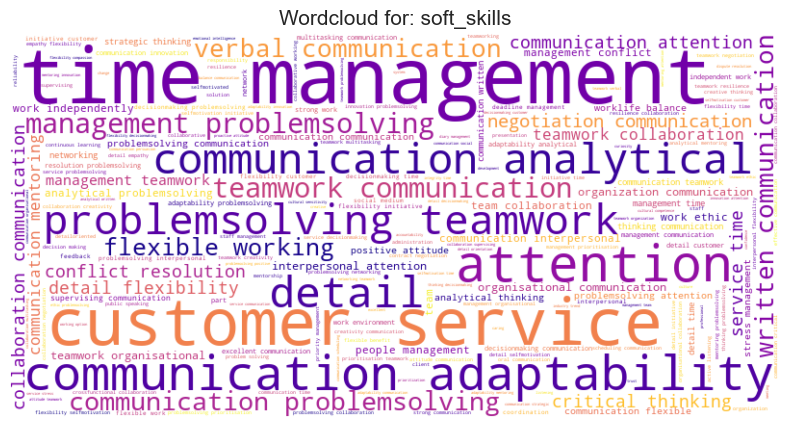

In [8]:
plot_wordcloud('soft_skills') 

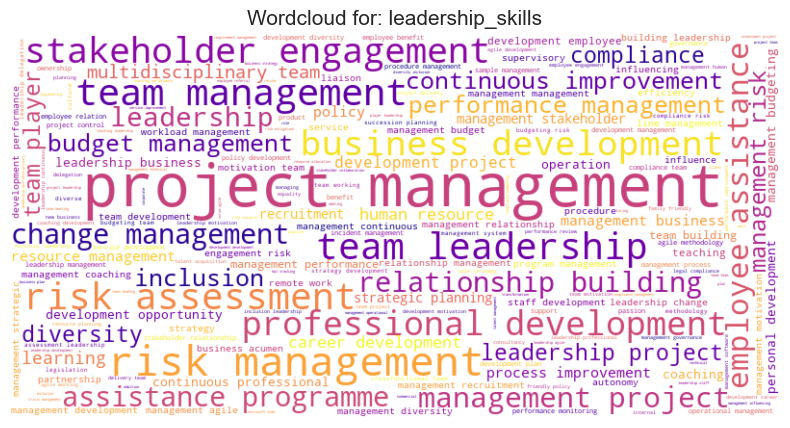

In [9]:
plot_wordcloud('leadership_skills') 

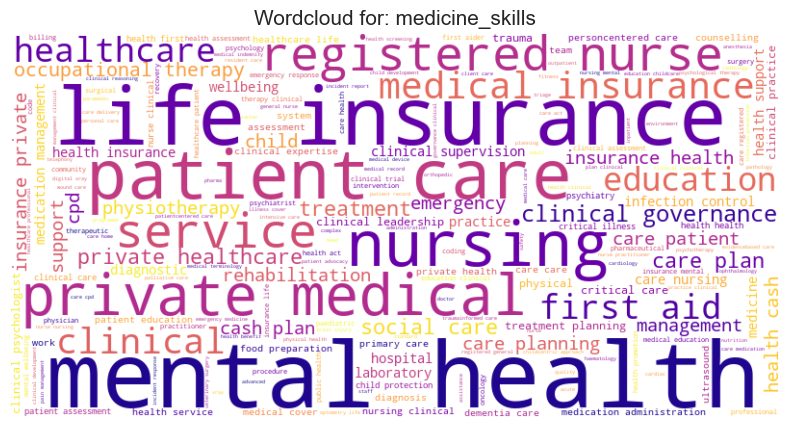

In [10]:
plot_wordcloud('medicine_skills') 

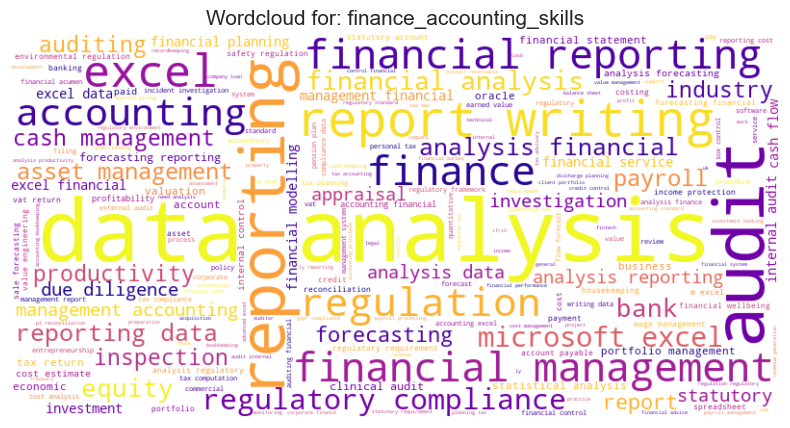

In [11]:
plot_wordcloud('finance_accounting_skills') 

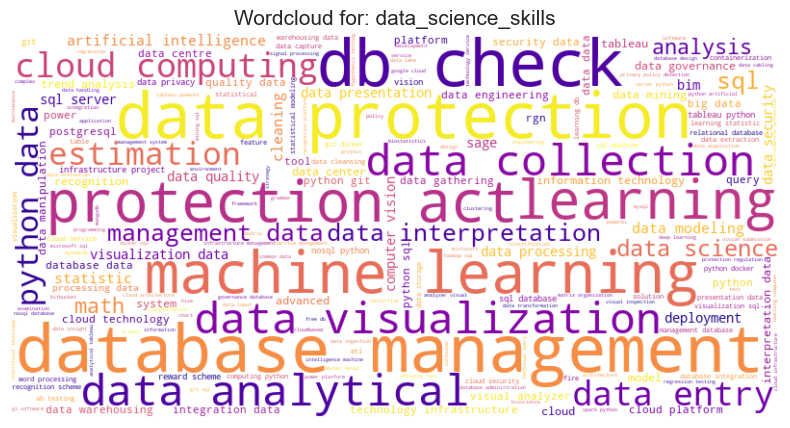

In [12]:
plot_wordcloud('data_science_skills') 

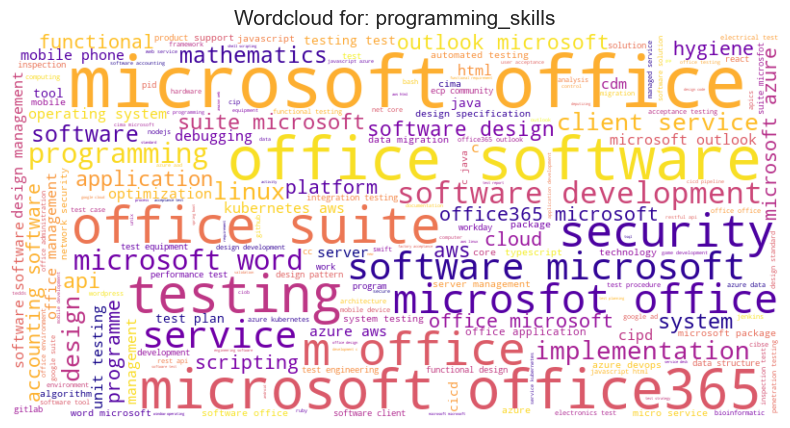

In [13]:
plot_wordcloud('programming_skills') 

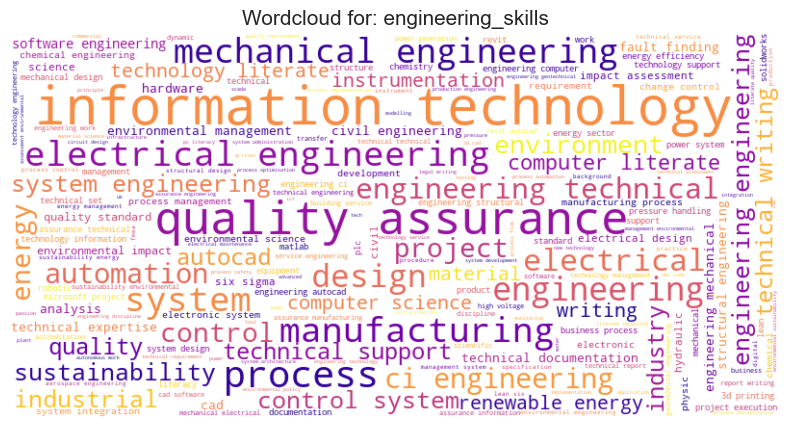

In [14]:
plot_wordcloud('engineering_skills')

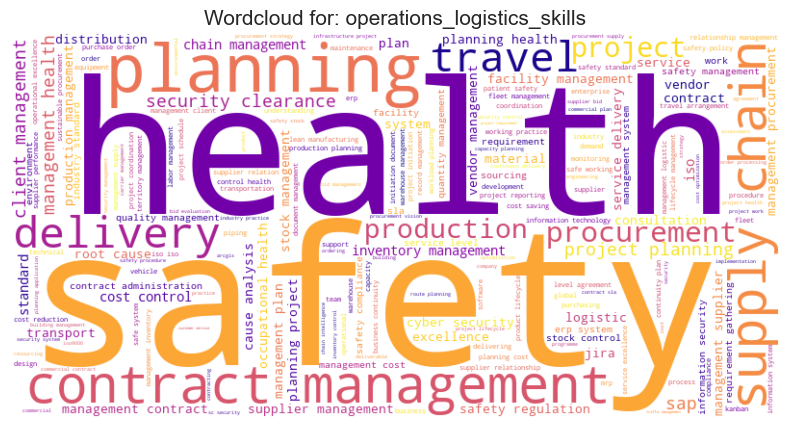

In [15]:
plot_wordcloud('operations_logistics_skills')

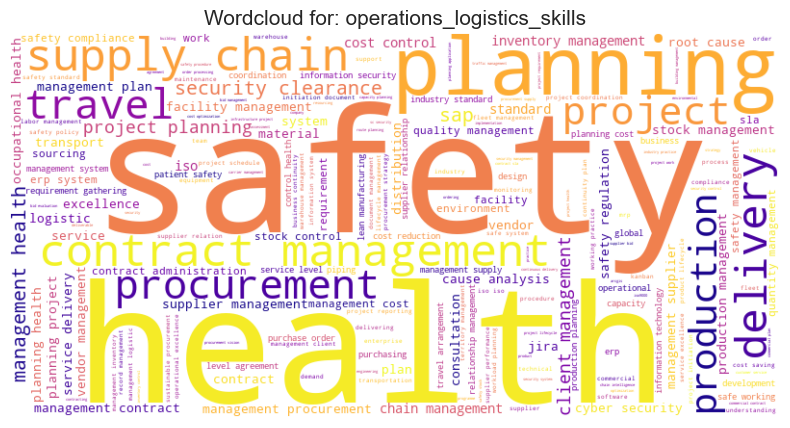

In [16]:
plot_wordcloud('operations_logistics_skills')

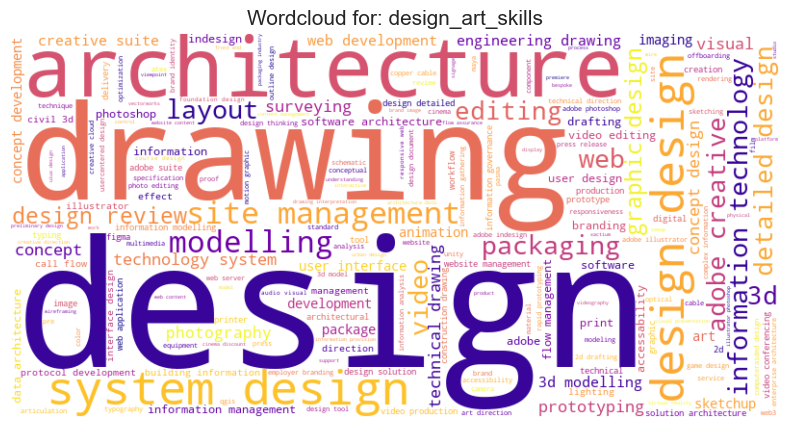

In [17]:
plot_wordcloud('design_art_skills')


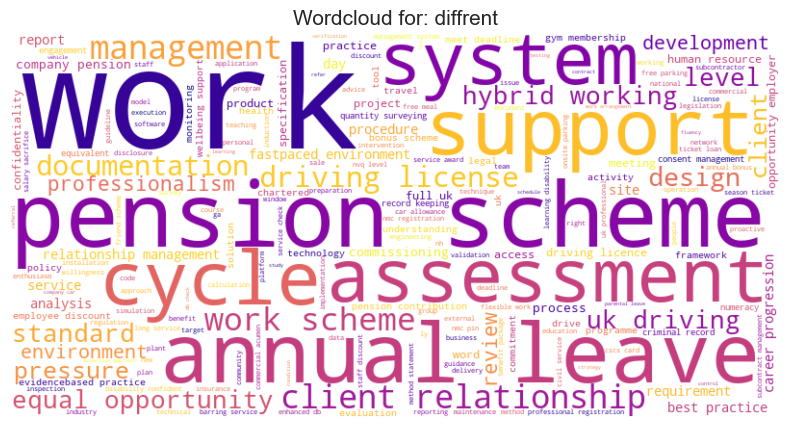

In [18]:
plot_wordcloud('diffrent')

In my opnion the wordclouds looks really nice - not only because I chose very nice colors for them - but also the most common words fit very nicly into the categories I've created. The only category that would need improvment is the design art one. Also I cosidered merging craftmanship and operational logistic one or data Science and programming - becaus ethey seems quite simmilar, but when going throught skills listed in each category I decided that this separation is valid

***

**Most common words in clusters**

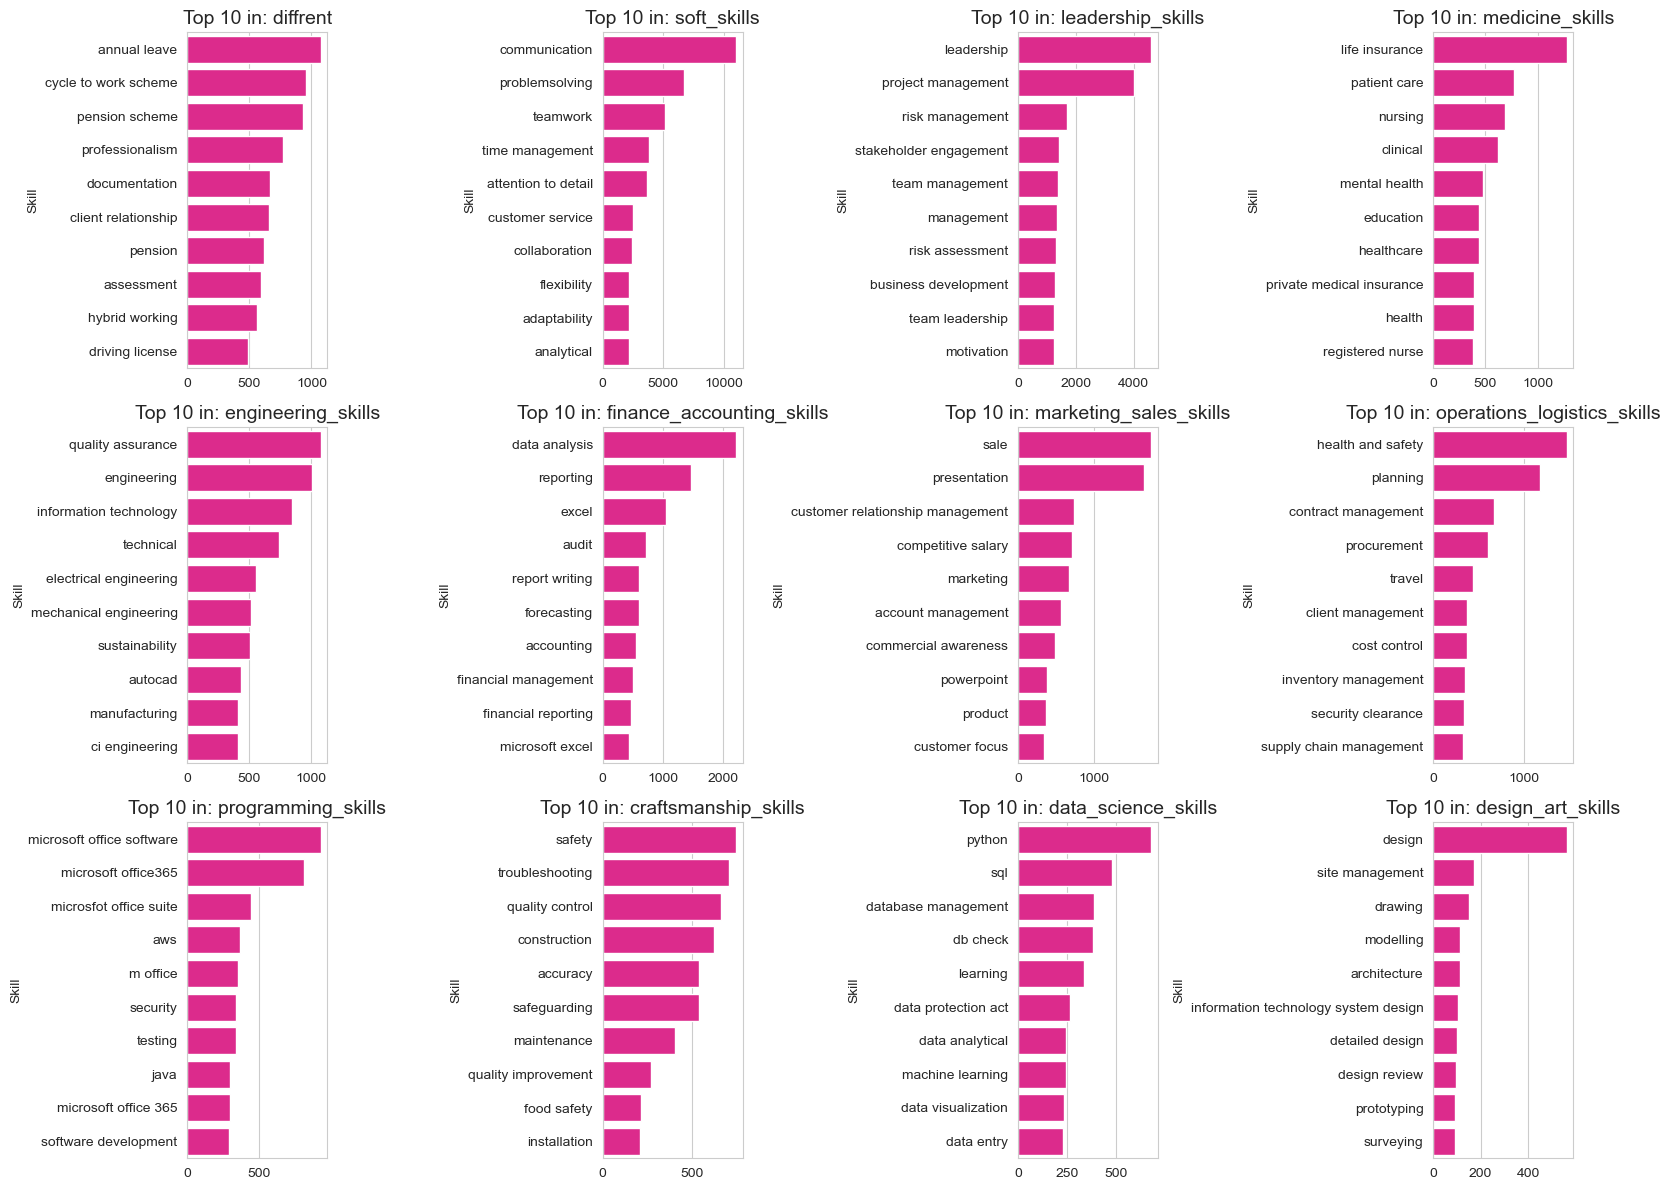

In [19]:
top_4_clusters = cluster_counts.index[:12]

fig, axes = plt.subplots(3, 4, figsize=(16, 12)) 
axes = axes.flatten()

for i, cluster_name in enumerate(top_4_clusters):
    
    subset = df_viz[df_viz['Cluster'] == cluster_name]
    
    top_skills = subset['Skill'].value_counts().head(10)
   
    sns.barplot(x=top_skills.values, y=top_skills.index, ax=axes[i], color= "#f90e8f")
    axes[i].set_title(f'Top 10 in: {cluster_name}', fontsize=14)
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

***

## Checking for model requirements

With created table for further project parts, we need to check if the data pass the requiremnts for the clustering and classification algorithm. In this part we will look at:

* Distribuition of each feature
* Correlation between features
* Outliers
With checking this and making appropiate changes the dataset will be more suitable fo the next parts - without redundency or ouliers destoring the outcomes.

***

**Distriubution of each feature** 

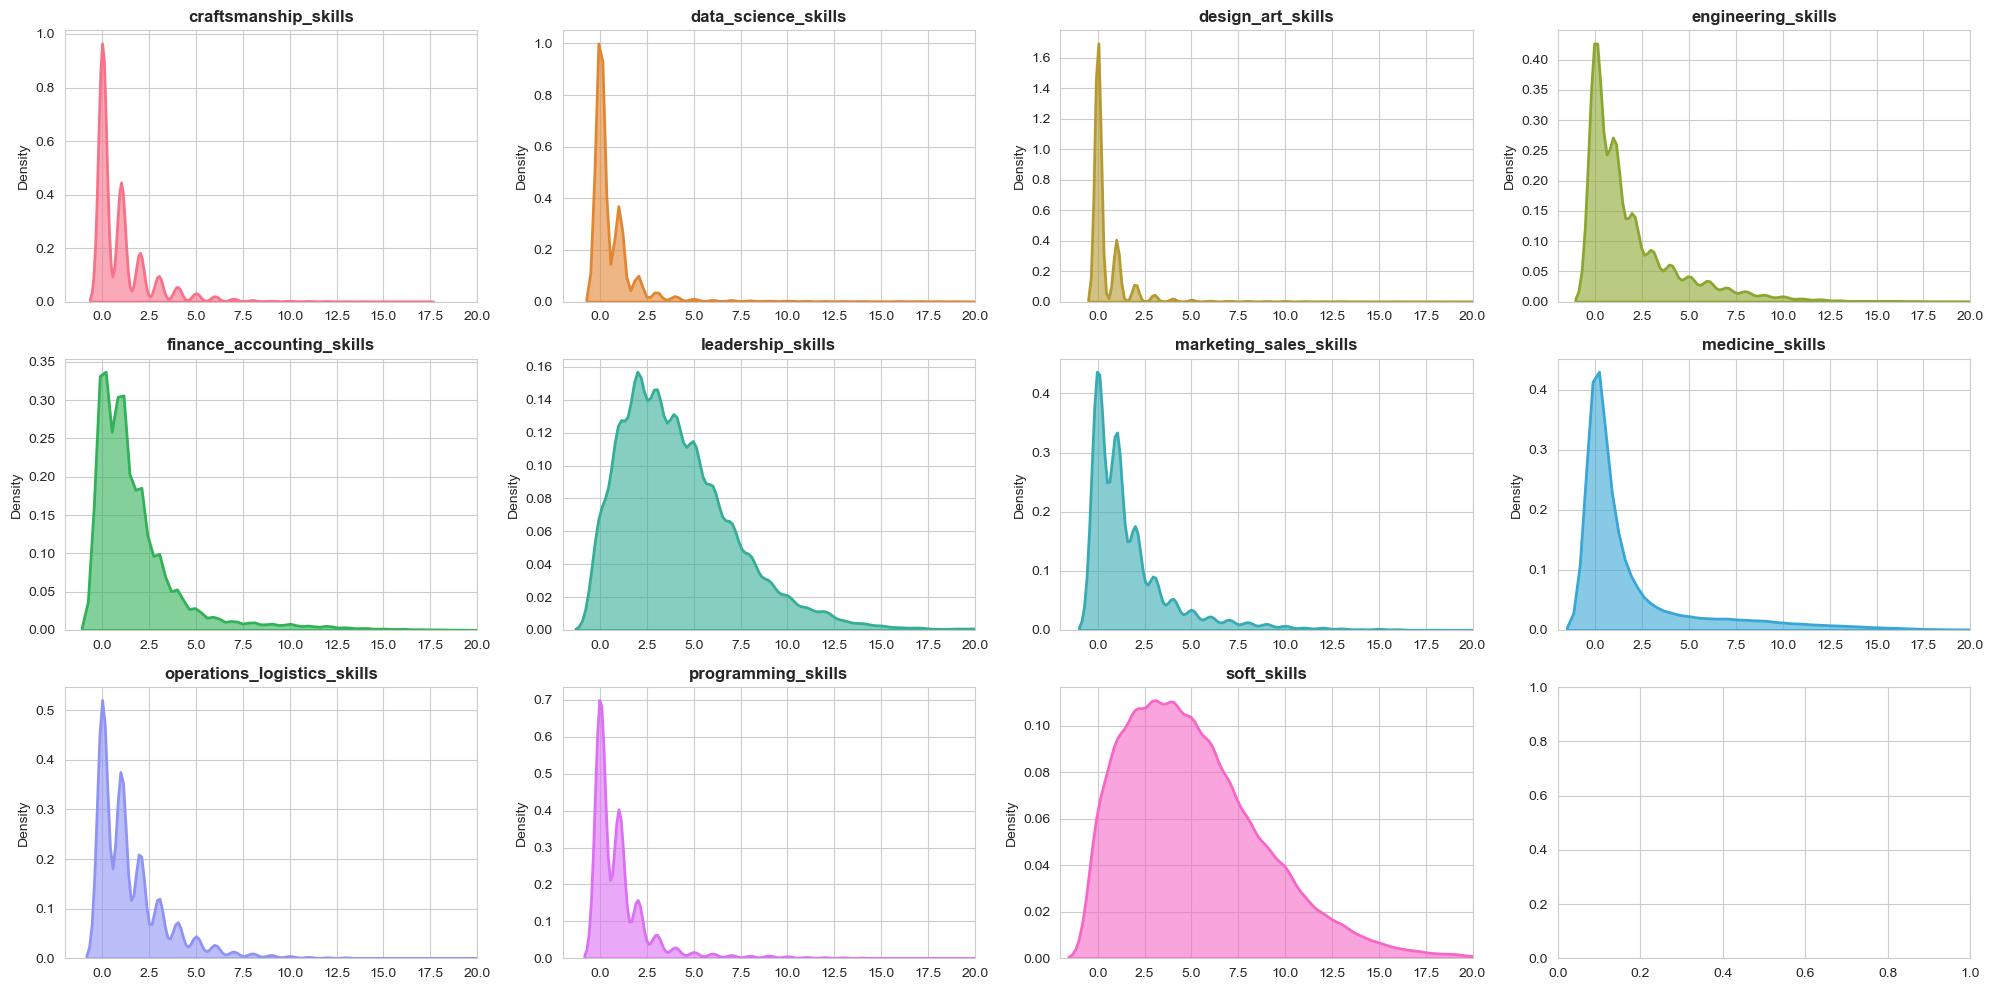

In [20]:
df_master = df_matrix.drop(columns=['ÿjob_link', 'diffrent'])

def get_global_statistics(data):
  
    df_numeric = data.select_dtypes(include=[np.number])
    stats = pd.DataFrame(index=df_numeric.columns)

    stats['Mean'] = df_numeric.mean()
    stats['Median'] = df_numeric.median()
    stats['Max'] = df_numeric.max()
    stats['Std'] = df_numeric.std()
    stats['CoV'] = stats.apply(lambda x: x['Std'] / x['Mean'] if x['Mean'] != 0 else np.nan, axis=1)
    stats['Skewness'] = df_numeric.skew()
    stats['Kurtosis'] = df_numeric.kurt() 

    
    return stats.round(3)

sns.set_style("whitegrid")  
colors = sns.color_palette("husl", 11) 

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 10)) 
axes = axes.flatten() 

for i, col in enumerate(df_master.columns):
    
    sns.kdeplot(
        data=df_master, 
        x=col, 
        ax=axes[i], 
        fill=True,     
        color=colors[i],
        alpha=0.6,      
        linewidth=2    
    )
   
    axes[i].set_title(col, fontsize=12, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Density')
    axes[i].set_xlim(-2, 20)
    

plt.tight_layout() 
plt.show()



In [21]:
get_global_statistics(df_master)

Mean  Median  Max    Std    CoV  Skewness  \
craftsmanship_skills         0.998     0.0   17  1.585  1.588     2.647   
data_science_skills          0.725     0.0   41  1.755  2.421     5.988   
design_art_skills            0.486     0.0   26  1.223  2.516     5.570   
engineering_skills           1.874     1.0   31  2.579  1.376     2.286   
finance_accounting_skills    1.842     1.0   61  2.633  1.429     3.584   
leadership_skills            4.200     4.0   32  3.163  0.753     1.378   
marketing_sales_skills       1.704     1.0   25  2.411  1.415     2.715   
medicine_skills              1.980     0.0   65  3.670  1.853     3.011   
operations_logistics_skills  1.576     1.0   26  2.038  1.293     2.458   
programming_skills           1.131     1.0   21  2.019  1.784     3.771   
soft_skills                  5.191     5.0   34  3.799  0.732     1.060   

                             Kurtosis  
craftsmanship_skills           10.101  
data_science_skills            56.280  
design_art_skills              49.774  
engineering_skills              7.682  
finance_accounting_skills      26.372  
leadership_skills               3.659  
marketing_sales_skills         10.478  
medicine_skills                15.826  
operations_logistics_skills    10.109  
programming_skills             19.191  
soft_skills                     1.796

All of the distribuituion plots were set to have a constant x axis range from -2 to 20 to show nicly the distibuition - without extrem values. With outliers we will deal in the near chapter. For now - discribing distribuition - it is clear that all of the distibuitions are highly right side skewed - they have more low values close to zero then they big values. This is very natural for that kind of data set - not every job posting will have skills from every gorup of skills. Leadership skills and soft skills seems to stand out from the rest of the distribution - they have the smallest skewness (around 1) - this is also natural for that dataset since we alredy check that those are the most popular categories. It is also not very strange for most jobs to have listed some soft/leadership skills. 

For this highly skewed distibuition, the mean is not a very relevant, because its being incresed by the small amount od extreme values that are not that relevant in the whole group. For example the mean in medice skills is almost 2 - that means that every job posting on average have 2 mnedicine skills listed? Of course not, for the better view in highly skeweed distibuitions it is crucial to use median. 

Most median are of course equal to 0 , but leadership skills and soft skills are very high: 4 and 5. 

For the Measures of Dispersion we can look the Coevicient of Variance (CoV) - neasures abouve 1 (100%) are very high - it means that data is wildy spread and the distibuition has heavy tails. For leadership/soft skills we see CoV = 75% which is saying that the data is not spread so much (the standard deviation is smaller then the mean). The same information goes with Kurtoris - the measure of shape - all the distribuition ar leptokurtic - it means that the data is highly centralized around the the mean with extrime values at the ends. 

***

**Looking for outliers**

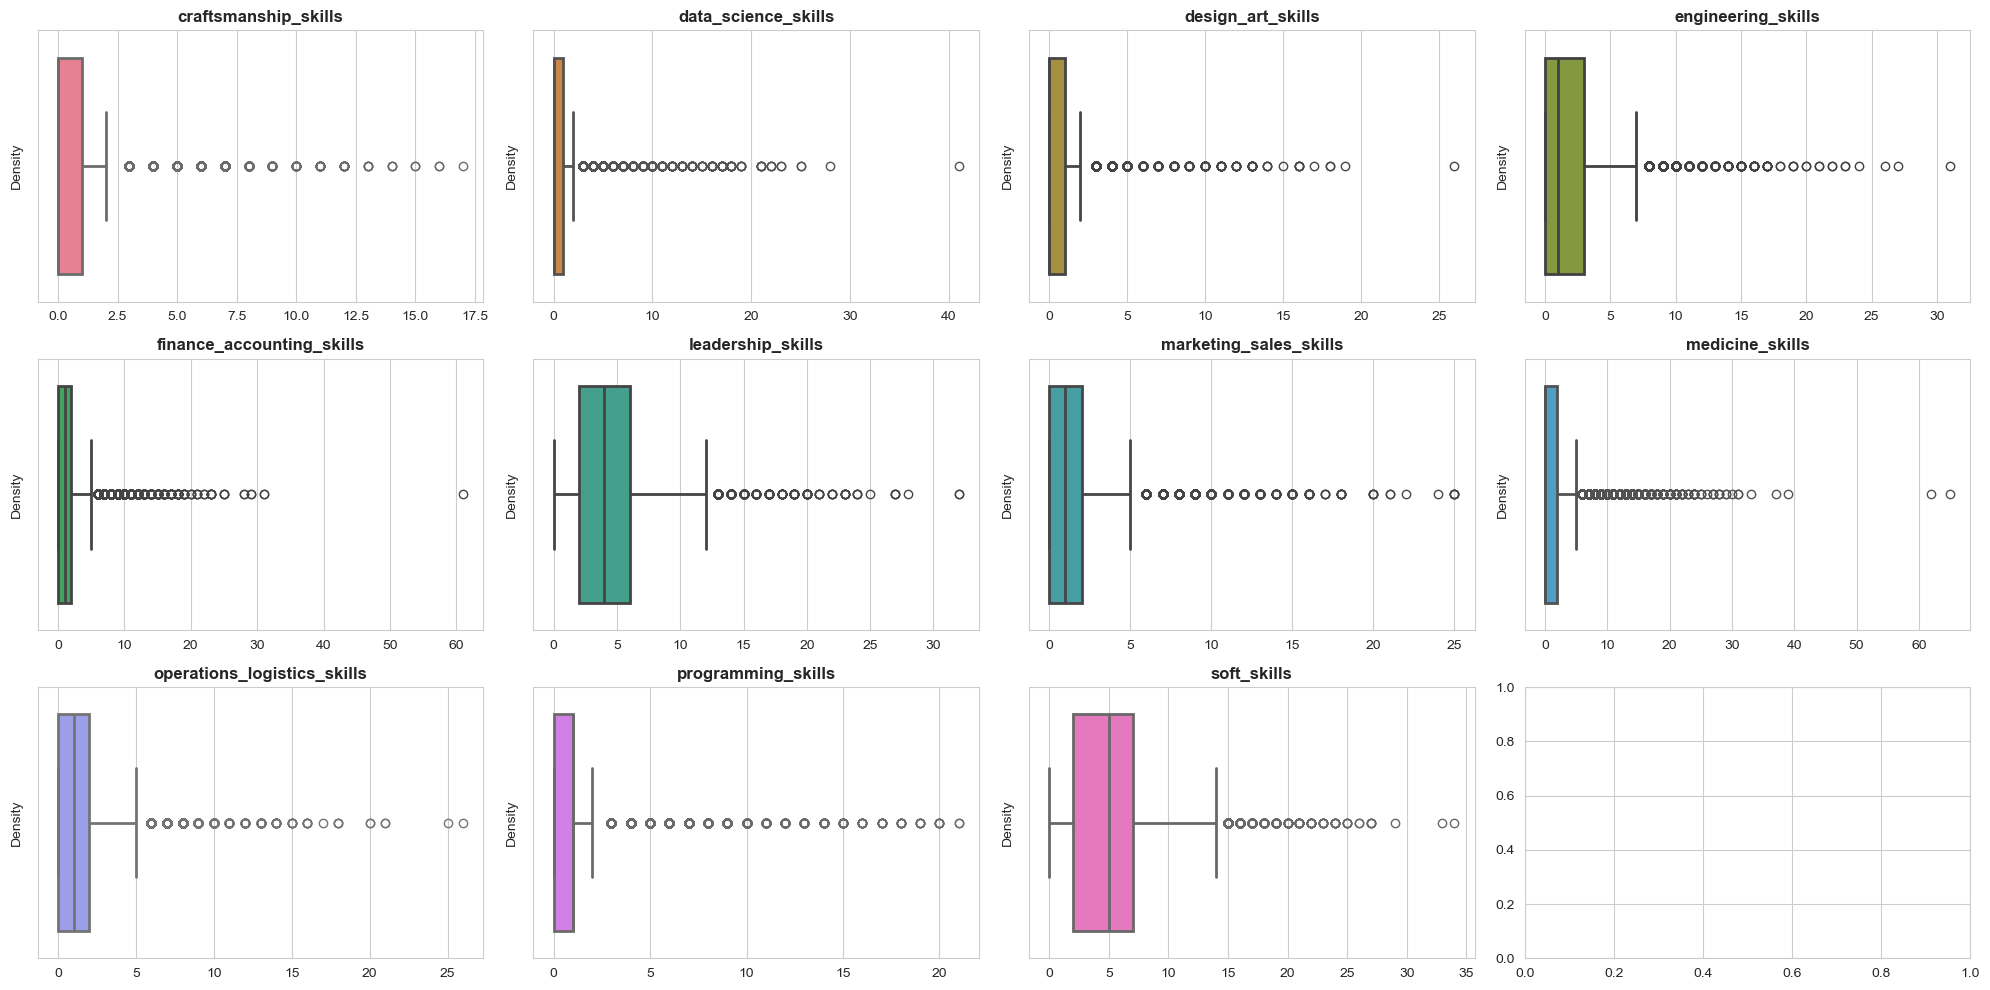

In [22]:
df_master = df_matrix.drop(columns=['ÿjob_link', 'diffrent'])

sns.set_style("whitegrid")  
colors = sns.color_palette("husl", 11) 

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 10)) 
axes = axes.flatten() 

for i, col in enumerate(df_master.columns):
    
    sns.boxplot(
        data=df_master, 
        x=col, 
        ax=axes[i], 
        fill=True,     
        color=colors[i],     
        linewidth=2    
    )
    

    axes[i].set_title(col, fontsize=12, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Density')

plt.tight_layout() 
plt.show()

Boxplots are very nice tool to look for the outliers and check the distibuition. We can see that those groups have a lot of outliers which might casuse problem later. First I suspect that sometimes there is so much skills listed from one group because they are simply repetition wrote a bit diffrent. Let me check that by pulling job offers with most skills listed from each category. 


In [23]:

skill_columns = df_matrix.select_dtypes(include=[np.number]).columns

results = []
for col in skill_columns:

    max_val = df_matrix[col].max()

    max_link = df_matrix[df_matrix[col] == max_val]['ÿjob_link'].values[0]

    
    results.append({
        'Category': col,
        'Max value': max_val,
        'Link fo the offer': max_link,
        
    })


df_champions = pd.DataFrame(results)

pd.set_option('display.max_colwidth', None) 
display(df_champions)

Category  Max value  \
0          craftsmanship_skills         17   
1           data_science_skills         41   
2             design_art_skills         26   
3                      diffrent         67   
4            engineering_skills         31   
5     finance_accounting_skills         61   
6             leadership_skills         32   
7        marketing_sales_skills         25   
8               medicine_skills         65   
9   operations_logistics_skills         26   
10           programming_skills         21   
11                  soft_skills         34   

                                                                                                                                        Link fo the offer  
0                                                                       https://uk.linkedin.com/jobs/view/toolroom-manager-at-willcox-matthews-3798147085  
1                                                                        https://uk.linkedin.com/jobs/view/data-architect-at-marc-jehotte-sprl-3803891580  
2                                                                                 https://uk.linkedin.com/jobs/view/brand-designer-at-butlin-s-3793598082  
3                                          https://uk.linkedin.com/jobs/view/senior-systems-engineer-iii-%e2%80%93-networks-transport-at-tesco-3744063838  
4                                                           https://uk.linkedin.com/jobs/view/energy-analyst-grid-stability-operability-at-ghd-3711248224  
5                                          https://uk.linkedin.com/jobs/view/vacancy-att-cta-tax-graduate-programme-summer-2024-at-menzies-llp-3756139157  
6                                                                              https://uk.linkedin.com/jobs/view/head-of-school-of-law-at-omni-3806518320  
7                                                               https://uk.linkedin.com/jobs/view/senior-marketing-manager-at-cms-distribution-3794121511  
8   https://uk.linkedin.com/jobs/view/consultant-psychiatrist-in-older-adult-psychiatry-at-surrey-and-borders-partnership-nhs-foundation-trust-3802097404  
9                                                             https://uk.linkedin.com/jobs/view/piping-and-layout-design-engineer-at-itm-power-3802778116  
10                                 https://uk.linkedin.com/jobs/view/business-development-manager-business-applications-and-data-ai-at-avanade-3721926149  
11                                          https://uk.linkedin.com/jobs/view/energy-systems-innovation-lead-ofgem-programme-x2-at-innovate-uk-3801249215

In [24]:
max_values = df_scraped[df_scraped['ÿjob_link'].isin(df_champions['Link fo the offer'])]
display(max_values['scraped_skill'])

2                                                                                                                                                                                                                                                              [piping and bulk material take offs, material requirement, multidisciplinary team, pipework design, job specification, piping specification, insulation, building legislation, modal analysis, construction planning, compliance, asme b31.1, reference pid, valve data sheet, applicable standard, oil and gas, asme b31.1b31.3, interface with client, code, soec, conceptual engineering, mechanical data, standard, nonconformance, flow, 3d cad model, technical bid tabulation, client meeting, nozzle loading, piping flexibility analysis, petrochemical, specification, piping and layout engineering, international code, ammonia, detailed design, material corrosion study, piping routing, interface with third party, plastic pipework, international stand

With this I belive my suspects where thru - most of those skills are extremaly simmilar. At the same time those jobs looks valid, not like extremly outstanding job postings. Thts why my method to get rid of this is setting cap on number of skills. What I mean by it is - every count that is higher than 20 is going to be lowered to 20, because its also an extreme value but not 'outlier' extreme. One again I want to remind that in this project outliers are expected - there will be a lot of 0 values and less bigger values. Those job postings with bigger values are of course very valuable, thats why I want to just lower their values to 20, not delete them

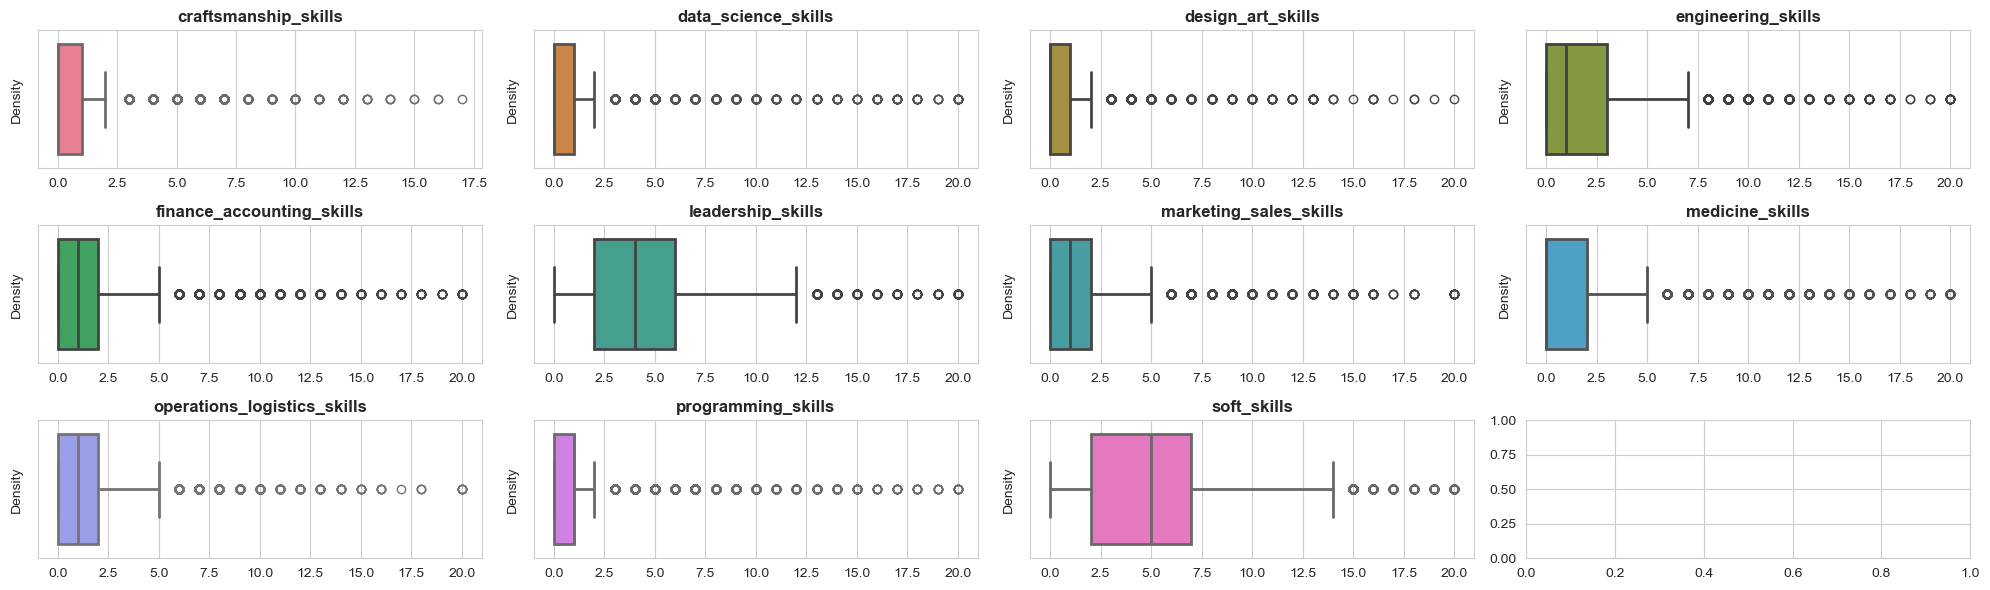

In [25]:
df_capped = df_master.clip(upper=20)

sns.set_style("whitegrid")  #
colors = sns.color_palette("husl", 11) 

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 6)) 
axes = axes.flatten() 

for i, col in enumerate(df_capped.columns):

    sns.boxplot(
        data=df_capped, 
        x=col, 
        ax=axes[i], 
        fill=True,     
        color=colors[i],     
        linewidth=2    
    )
    
    
    axes[i].set_title(col, fontsize=12, fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Density')

plt.tight_layout() 
plt.show()

In my opinion now it looks a bit better than befor. The nest step is - what if jobs are not outliers because of single column but because of combination of number of skills. To find those kind of jobs I will use PCA and identify then visualy

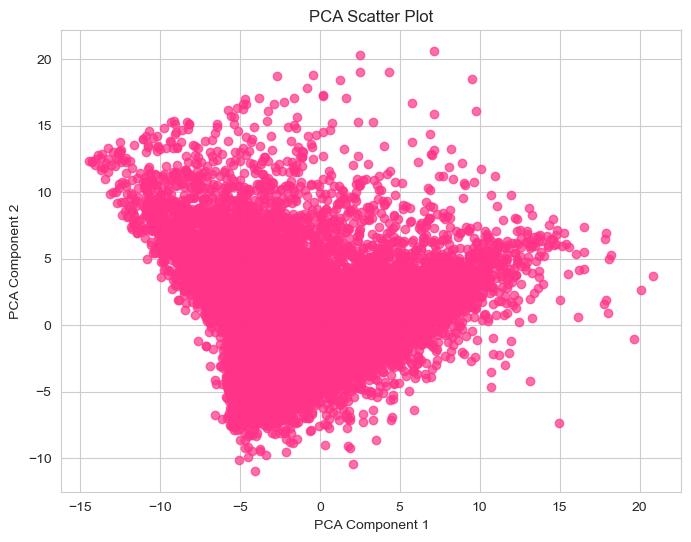

In [26]:
X = df_capped
scaler = MinMaxScaler()
pca = PCA(n_components=2)
X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], color="#FF3388", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Scatter Plot")
plt.grid(True)
plt.show()

There are for sure 'dots' that are far away from the collective group and i want to get rid of them. One way would be just deleting items based on theirs PCA1 and PCA2 values, but this approach makes it hard to tail it good enougth. Second idea is to use a db scan alorithm and let it decide which ones are outliers. 

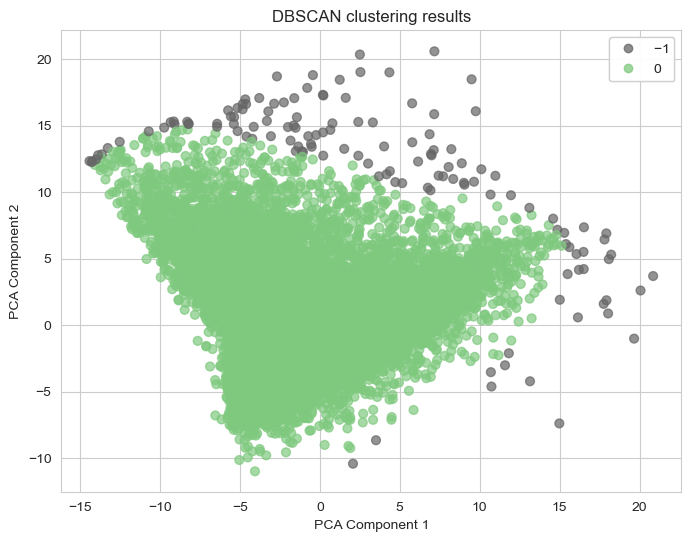

In [27]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=2.5, min_samples=100) 
clusters = dbscan.fit_predict(X_pca)

def dbscan_visualization( X_pca, labels_cure):

    fig, ax = plt.subplots()
    fig.set_figheight(6)
    fig.set_figwidth(8)
    scatter1 = plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_cure, s=40, cmap= 'Accent_r', alpha=0.7)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("DBSCAN clustering results")
    legend = ax.legend(*scatter1.legend_elements())
    ax.add_artist(legend)
    plt.grid(True)
    plt.show()


dbscan_visualization(X_pca, clusters)

All of the ;grey points' are going to be deleted from the database beacuse they are outliers.

In [28]:

pca_df = pd.DataFrame(
    data=X_pca, 
    columns=['PCA1', 'PCA2'], 
    index=df_capped.index  
)

pca_df['Cluster'] = clusters

df_master2 = pd.merge(df_capped, pca_df[['Cluster']], left_index=True, right_index=True)

df_master2 = df_master2[df_master2['Cluster'] != -1]

**PCA after cleaning the data**

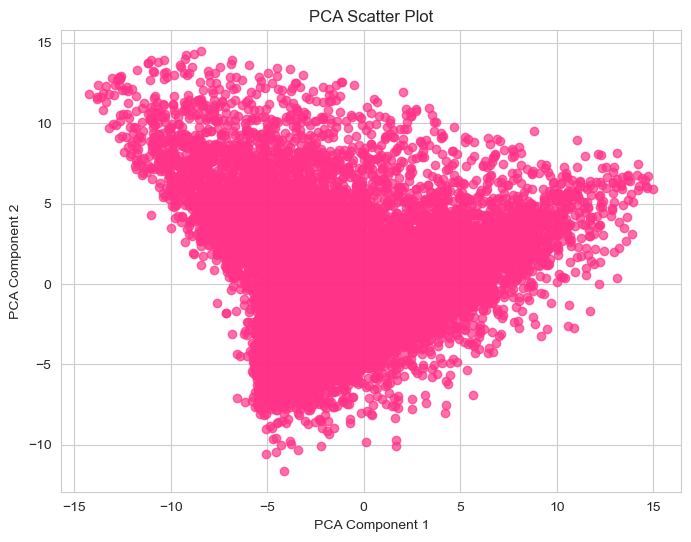

In [29]:
X = df_master2.drop(columns=['Cluster'])
scaler = MinMaxScaler()
pca = PCA(n_components=2)
X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], color="#FF3388", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Scatter Plot")
plt.grid(True)
plt.show()

***

**Checking the Redundency**

Of course as a last step we need to check for the redundecy after deletation of outilers to ensure the best results.

The Correlation matrix carries out a good message - the columns are not relly releted to ecah other. The highest value is 38% between data science skills and programming skills, which is still pretty low. With that information I stay with my choosing of columns and will not delete any. To visuzalize 4 strongest relationships in data, under this text, I;ve creted 4 scatter plots - also very usefull while assesing correlation.  

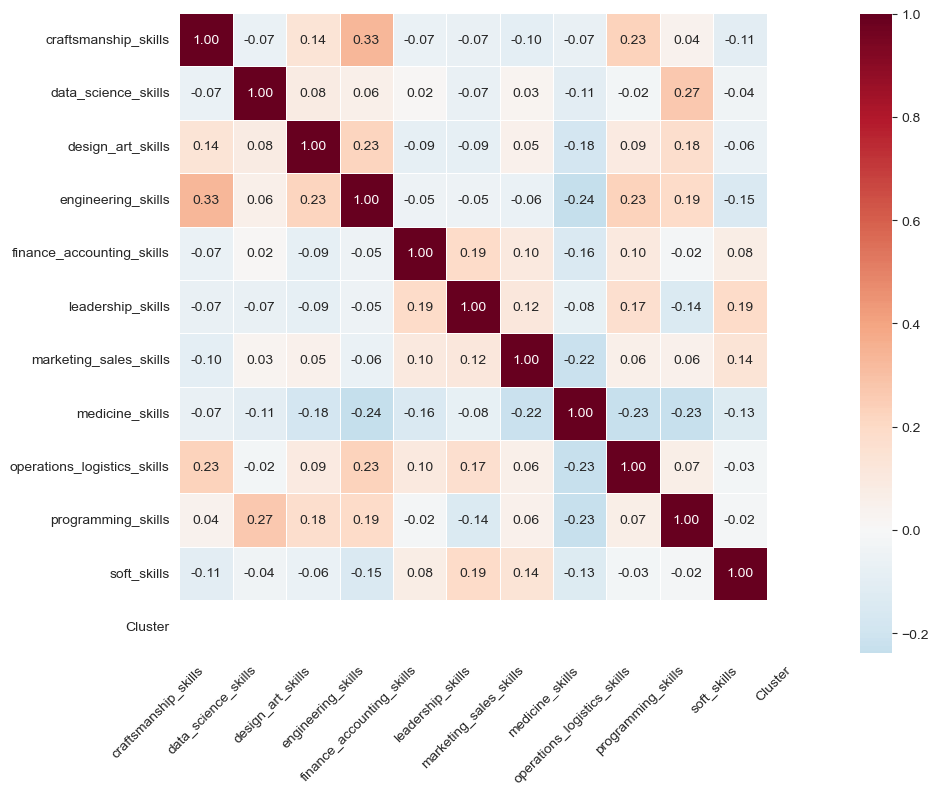

In [30]:
def plot_correlation_matrix(data, hide_upper=True):

    corr = data.select_dtypes(include=[np.number]).corr(method='spearman')

    mask = None
    if hide_upper:
        
        mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(10, 10)) 
    sns.set_style("white") 

    heatmap = sns.heatmap(
        corr,
        mask=mask,         
        annot=True,        
        fmt=".2f",         
        cmap='RdBu_r',     
        center=0,          
        square=True,       
        linewidths=0.5,    
        cbar_kws={"shrink": 0.7} 
    )

    
    plt.xticks(rotation=45, ha='right') 
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()

plot_correlation_matrix(df_master2, hide_upper=False)

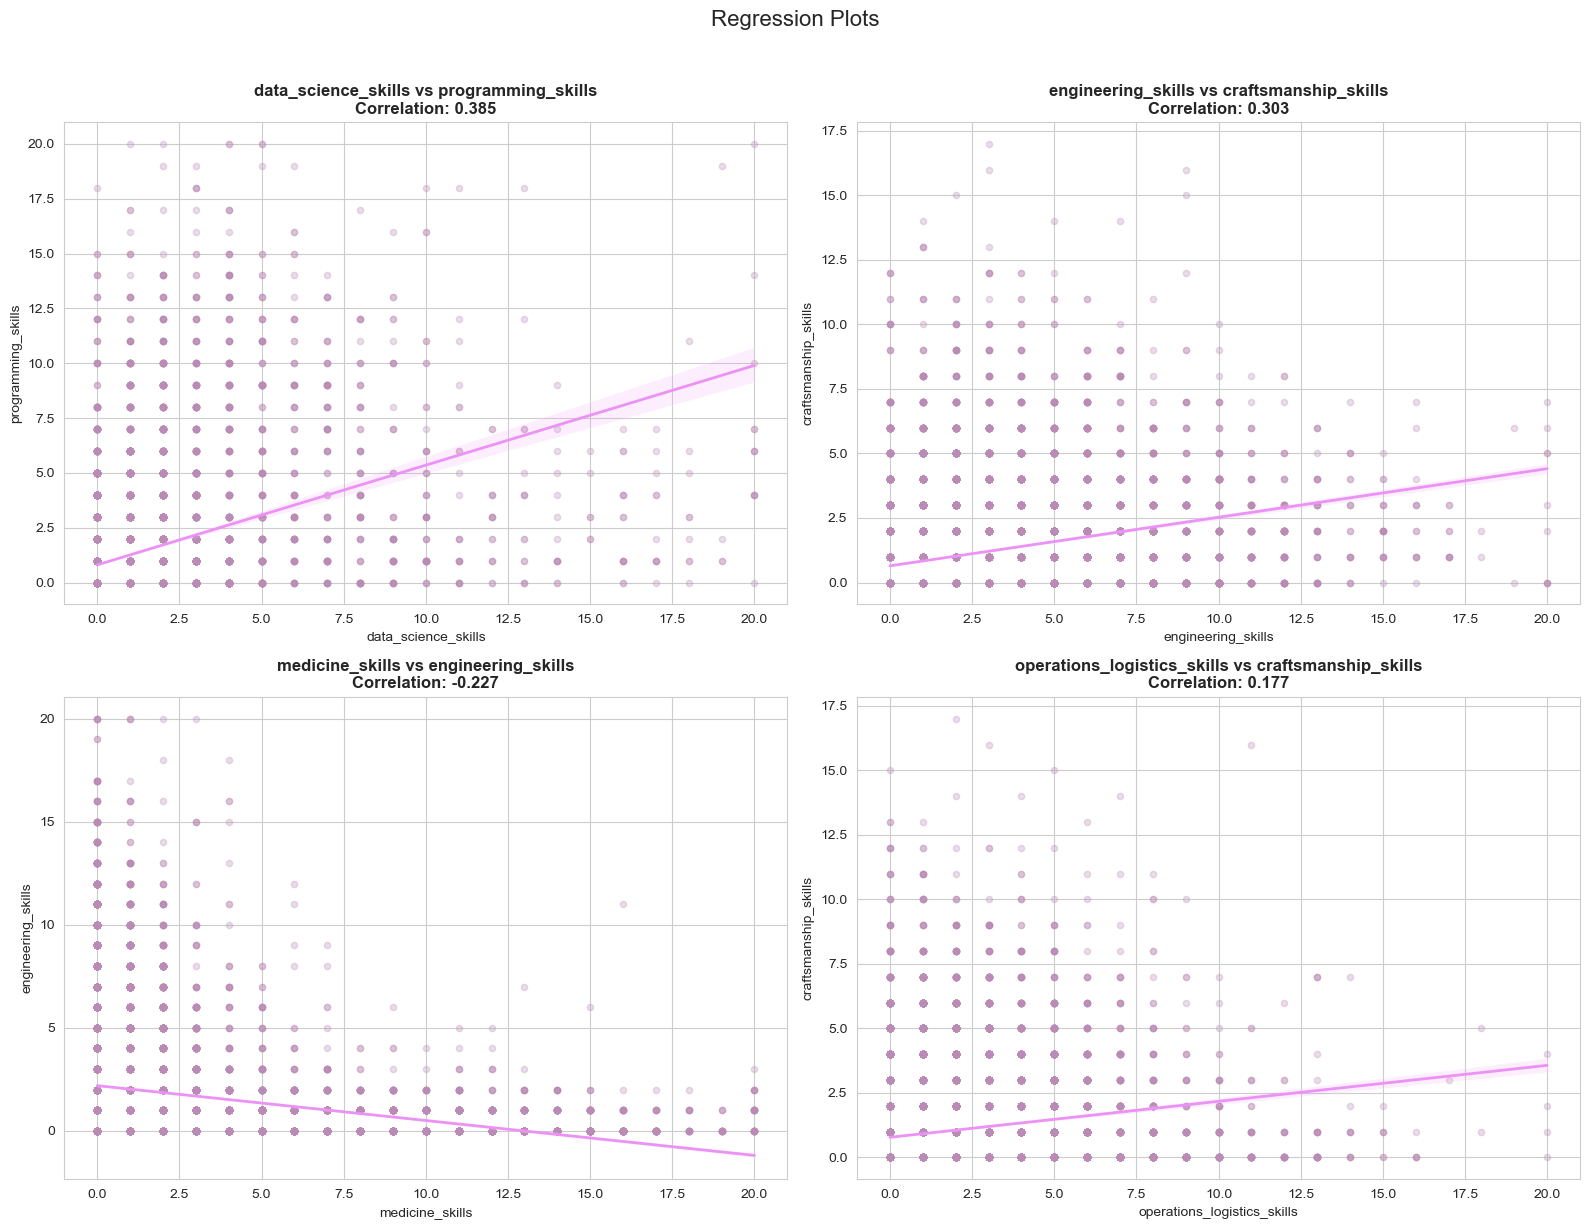

In [31]:
pairs_to_plot = [
    ('data_science_skills', 'programming_skills'),
    ('engineering_skills', 'craftsmanship_skills'),
    ('medicine_skills', 'engineering_skills'),
    ('operations_logistics_skills', 'craftsmanship_skills')
]

sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axes = axes.flatten() 


for i, (x_col, y_col) in enumerate(pairs_to_plot):
    
    
    corr = df_master2[x_col].corr(df_master2[y_col])

    sns.regplot(
        data=df_master2, 
        x=x_col, 
        y=y_col, 
        ax=axes[i],
        scatter_kws={'alpha': 0.3, 's': 20, 'color': "#ba8bb4"}, 
        line_kws={'color': "#ec92f6", 'linewidth': 2}           
    )
    
    
    axes[i].set_title(f"{x_col} vs {y_col}\nCorrelation: {corr:.3f}", fontsize=12, fontweight='bold')
    axes[i].set_xlabel(x_col)
    axes[i].set_ylabel(y_col)


plt.suptitle("Regression Plots", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

With this the Cleaning part is done - I can move on into the Clustering part 

# Clustering 

The aim of this part is to create reliable clusters that will represent real-life sectors of job postings on LikedIn. To do this, the skills were grouped into larger segments e.g. soft skills/ programming skills/ tech-skills/ medicine skills and new dataset was made. To ensure the best possible results, 2 algorithms of clustering were tested and evaluated: **K-means**, **K-medioids** . For the job recomendation system, clustering with the best performance will be selected. I resigne from doing herarhical clustering and dbscan algorithm as clustering becasuse both were highly missunderstanding and the choosing of paramethers was impossible to do. That is why I stayed with those two options.

To ease a process of assesing clustering, besides technical measures, the results will be visualized on 2-dimensional sccater plot after dimension reduction completed with Principal Component Analysis. 

***

## Metrics for clustering evaluation 

In this project, there is no ground truth, thats why measures used during assesing clusters are:

* **Silhouette Score** - how well each point fits within its assigned cluster compared to other clusters.
* **David-Bouldin Index** - evaluates clustering by comparing cluster compactness and the distance between clusters.
* **Calinski–Harabasz Index** - also known as the Variance Ratio Criterion, measures the ratio of between-cluster dispersion to within-cluster dispersion.


In [32]:
def clustering_metrics(data, cluster_labels):
    X = data.values

    metrics = {
        "Silhouette Score": silhouette_score(X, cluster_labels),
        "Davies-Bouldin Index": davies_bouldin_score(X, cluster_labels),
        "Calinski-Harabasz Index": calinski_harabasz_score(X, cluster_labels)
    }

    
    df = pd.DataFrame(
        [{"Metric": k, "Value": round(v, 4)} for k, v in metrics.items()]
    )

    return df


def cluster_statistics(data, cluster_labels):
    data = data.copy()
    data['Cluster'] = cluster_labels
    feature_names = data.columns.drop('Cluster')
    
    cluster_dfs = {}
    
    for cluster, group in data.groupby('Cluster'):
        stats_list = []
        for feature in feature_names:
            col = group[feature].dropna()
            stats_list.append({
                'Feature': feature,
                'Mean': round(col.mean(), 3),
                'Std': round(col.std(), 3),
                'CoV': round(col.std()/col.mean() if col.mean() != 0 else np.nan, 3),
                'Skewness': round(col.skew(), 3),
                'Kurtosis': round(kurtosis(col, fisher=True, bias=False), 3)
            })
        cluster_dfs[cluster] = pd.DataFrame(stats_list).T
    
    return cluster_dfs

***
## K-means 

K-means is one of the most widely used unsupervised learning algorithms for discovering structure in data by grouping observations into k clusters. The goal of the algorithm is to partition the data so that points within the same cluster are as similar as possible, while clusters themselves are well separated.

The algorithm works iteratively in two main steps:

* **Assignment step** – each data point is assigned to the nearest cluster center (centroid) based on a distance measure, typically Euclidean distance.

* **Update step** – new centroids are calculated as the mean position of all points assigned to each cluster.

For optimal results, k++ initizalization was used 

***

## Choosing number of k 

To determine the best fitting number of clusters (k), elbow plot will be created. To visualize where is the best number of clusters KMeans function was used, because it will be faster than to use ours authored function.

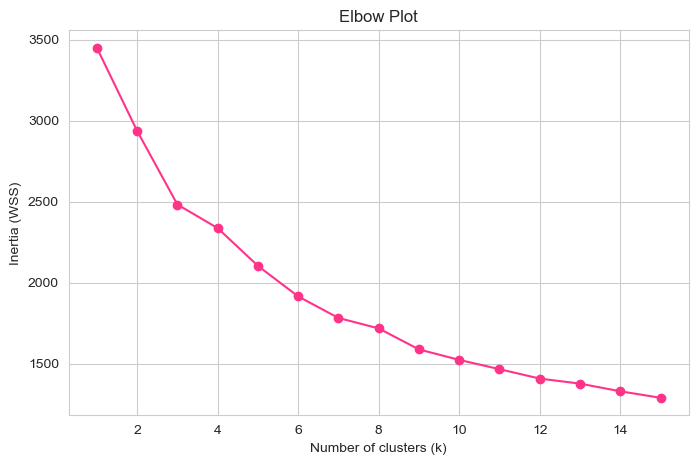

In [33]:
def plot_elbow(data, k_min=1, k_max=15):
    inertia_values = []

    for k in range(k_min, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertia_values.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(range(k_min, k_max + 1), inertia_values, marker='o', color = "#FF3388")
    plt.title('Elbow Plot')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia (WSS)')
    plt.grid(True)
    plt.show()

plot_elbow(X_scaled, k_min=1, k_max=15)

With this plot I decide to go on with 6 clusters for K-means and K-medioids

***

## Visualization and assesment of clustering

In [34]:
kmeans = KMeans(n_clusters=6, random_state=70)
kmeans.fit(X_scaled)
labels_means = kmeans.labels_

center_points_df = pd.DataFrame(kmeans.cluster_centers_)

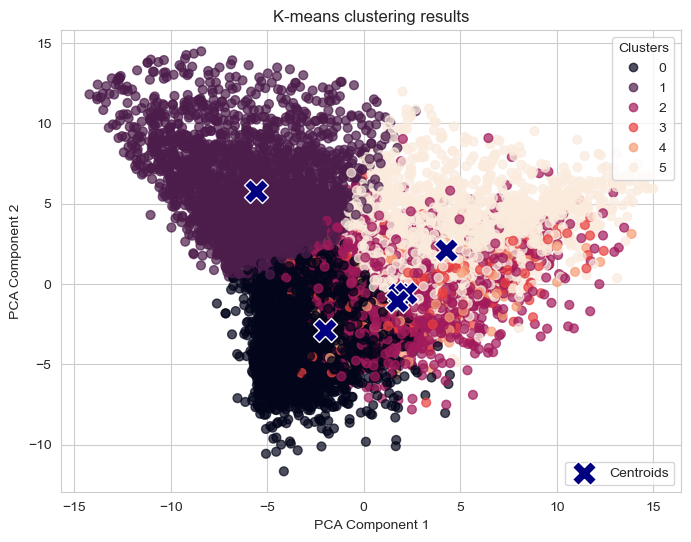

In [35]:


def kmeans_visualization(X_pca, data_disstances, center_points_df):
    
    cluster_labels = data_disstances

    cluster_centers = scaler.inverse_transform(center_points_df)
    cluster_centers_pca = pca.transform(cluster_centers) 

    fig, ax = plt.subplots()
    fig.set_figheight(6)
    fig.set_figwidth(8)

    scatter1 = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=40, alpha=0.7)

    scatter2 = ax.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1], c='navy',
                          s=300, edgecolors='white', marker='X', label='Centroids')

    legend1 = ax.legend(*scatter1.legend_elements(),
                        title="Clusters", loc="upper right")

    ax.add_artist(legend1)

    ax.legend(handles=[scatter2], loc="lower right")

    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")
    ax.set_title("K-means clustering results")
    ax.grid(True)
    
    plt.show()


kmeans_visualization(X_pca, labels_means, center_points_df)

As we can the, the dividing into clusters was quite succesfull- the plot is looking nice already. Its normal that cluster will layer on each other beacause of the type of data. So the statistics assesment for the cluster will probably not be great. 

**Statistics of clusters**

In [36]:
cluster_labels = labels_means


df_master2['Cluster'] = cluster_labels
numeric_cols = df_master2.select_dtypes(include=[np.number]).columns.drop('Cluster', errors='ignore')
cluster_means = df_master2.groupby('Cluster')[numeric_cols].mean()
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(cluster_means), 
                         columns=cluster_means.columns, 
                         index=cluster_means.index)

display(df_scaled.head())   

craftsmanship_skills  data_science_skills  design_art_skills  \
Cluster                                                                 
0                    1.000000             1.000000           0.971807   
1                    0.051390             0.000000           0.000000   
2                    0.438457             0.319203           0.289809   
3                    0.034422             0.344117           1.000000   
4                    0.000000             0.387911           0.079466   

         engineering_skills  finance_accounting_skills  leadership_skills  \
Cluster                                                                     
0                  1.000000                   0.032855           0.000000   
1                  0.000000                   0.000000           0.101344   
2                  0.387199                   0.111318           1.000000   
3                  0.139051                   0.093127           0.233897   
4                  0.074258                   1.000000           0.288274   

         marketing_sales_skills  medicine_skills  operations_logistics_skills  \
Cluster                                                                         
0                      0.073330         0.041856                     0.672940   
1                      0.000000         1.000000                     0.000000   
2                      0.138759         0.061399                     1.000000   
3                      1.000000         0.012734                     0.295627   
4                      0.081856         0.000000                     0.276363   

         programming_skills  soft_skills  
Cluster                                   
0                  1.000000     0.000000  
1                  0.000000     0.089209  
2                  0.262556     0.250125  
3                  0.351786     0.372207  
4                  0.345945     0.272890

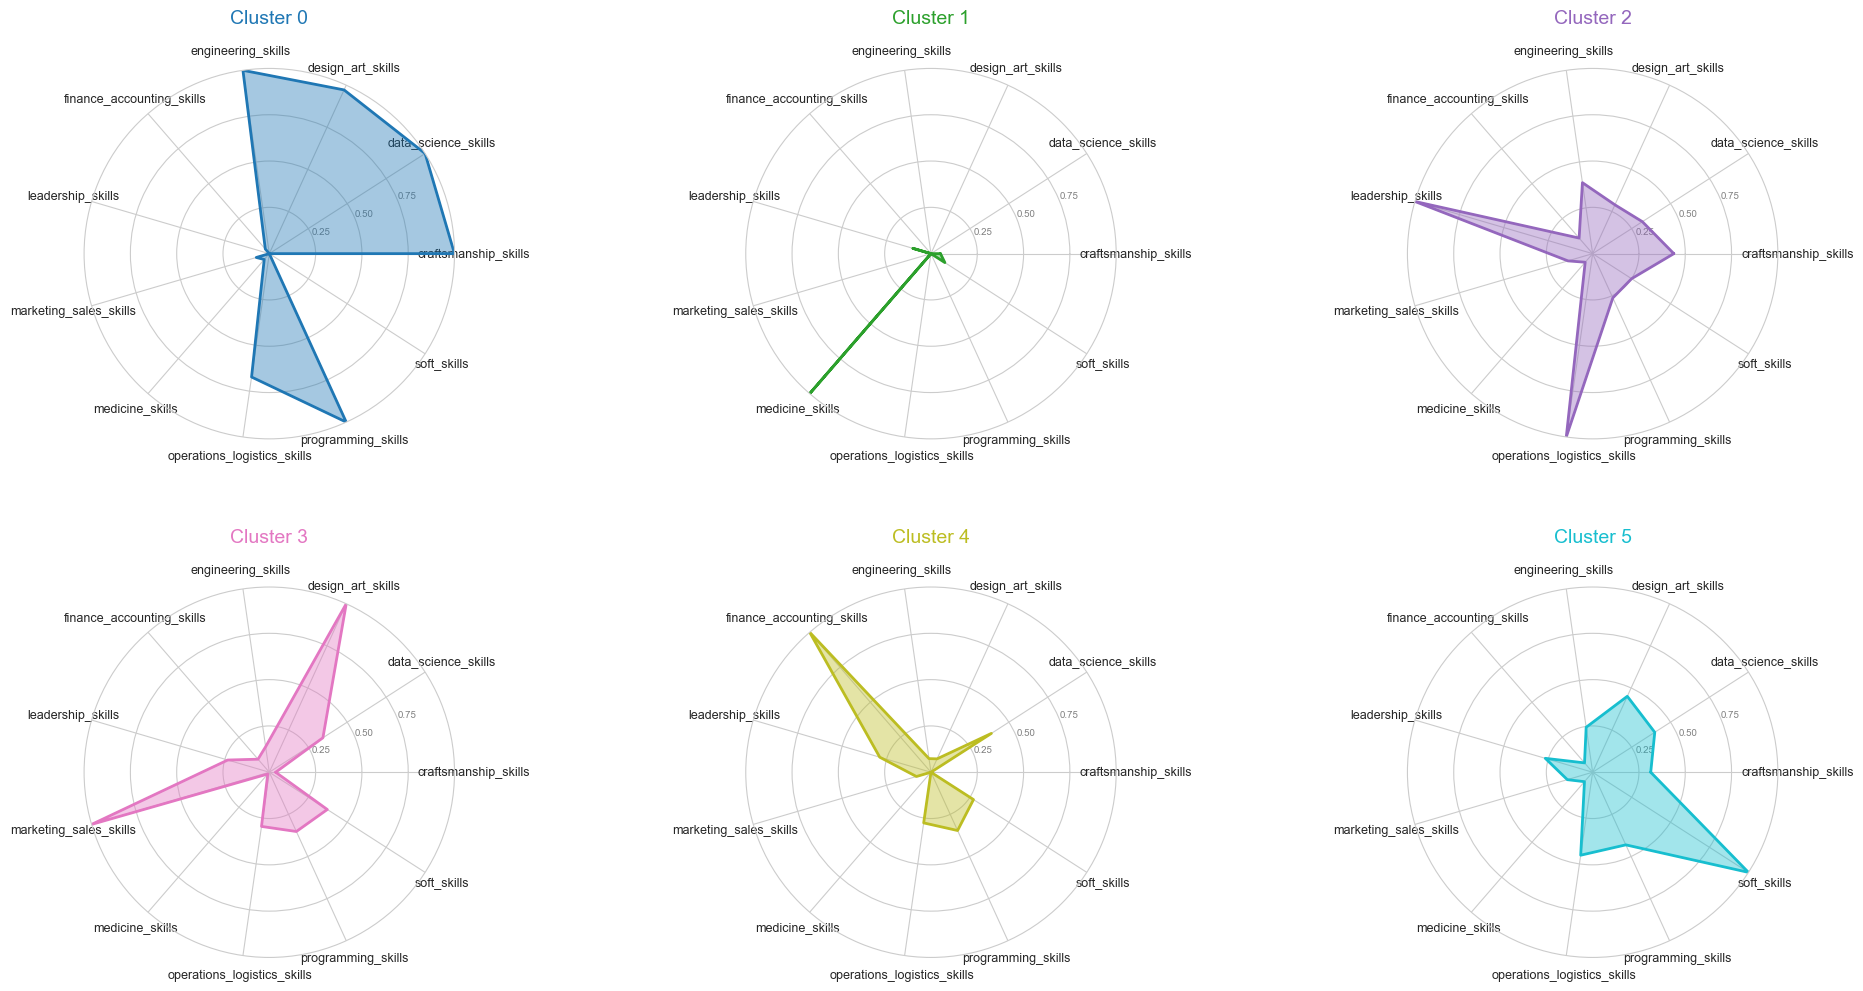

In [37]:

def make_spider_plot(df, row, title, ax, color):

    categories = list(df.columns)
    N = len(categories)

    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1] 
    values = df.loc[row].values.flatten().tolist()
    values += values[:1]

    ax.plot(angles, values, linewidth=2, linestyle='solid', color=color, label=title)
    ax.fill(angles, values, color=color, alpha=0.4) 

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=9)
 
    ax.set_ylim(0, 1)
    ax.set_yticks([0.25, 0.5, 0.75])
    ax.set_yticklabels(["0.25", "0.50", "0.75"], color="grey", size=7)

    ax.set_title(title, size=14, color=color, y=1.1)

colors = plt.cm.get_cmap("tab10", 6)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), subplot_kw=dict(polar=True))
axes = axes.flatten() 

for i, cluster_id in enumerate(df_scaled.index):
    make_spider_plot(
        df=df_scaled, 
        row=cluster_id, 
        title=f"Cluster {cluster_id}", 
        ax=axes[i], 
        color=colors(i)
    )

for j in range(len(df_scaled), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(hspace=0.4) 

**Clusters characterisation**

***

* **Cluster 0**: The Tech and Data Wizard

*Dominant skills*: Data Science, Programming, Engineering, Caftsmanship and Design

*Example positions*: Data Scientist/ Data Analyst/ Software Engineer (Backend/Fullstack)/ Machine Learning Engineer/ DevOps Specialist

This is cleraly cluster of highly tech jobs, demaning mosty hard skills like programming languages, knowing diffrent softwares ect.

___

* **Cluster 1**: Medical Field expert

*Dominant skills*: Medical skills

*Example positions*: Registered nurse/ CTS practitioner/ phisotherapist/ gynecologist

Withing this clusters we have jobs with only medical skills listed, and a small amount of soft skills. As we can see on K-means clustering visualization, this cluster is the biggest - which is supported by EDA results

***



* **Cluster2**: The Leader & People Manager

*Dominant skills*: Leadership skills, Soft sills, Operational skills

*Exmaple positions*: Project Manager/ Scrum Master/ HR Manager/ Recruiter/ Team Leader/ Office Manager 

This is classical set of skills for people working in managment - abilities to stair the team into the right direction


***

* **Cluster3**: The Creative Sales Force

*Dominant skills*: Marketing skills, Design art skills

*Exmaple positions*: Marketing Specialist/ Social Media Manager/ Graphic Designer / UX Designer/ Sales Representative/ Key Account Manager/ PR Specialist

The 3rd clusters represents the people working creativly. This combination is very obcious because the world of design and marketing are highly influenced by eachother - those are peple who need to know how to creat good and estetic marketing campains ect. 

***

* **Cluster4** : The Banking Backbone

*Dominant skills* : Finance and Accounting skills, Operations and Logistics skills

*Example positions*: Accountant/ Financial analysyst/ Supply Chain Manager/ Business analyst

This i scluster cleary made of corparate job - probably mostly in banking and finance. This match of financial skills and operational/logistics skills also, in my opnion, makes a good pair.

***

* **Cluster5**: A little bit of this a little bit of that

*Dominant skills*: Soft skills

*Example positions*: Infinity

This cluster probably bags jobs that does not really fall into any other category with just the most skills in soft category. So these might be gastronomy offers, legal sector offers, and many many more.

***

**Summary**

In the K-means result visualization we can see that 0,1 and 5th clusters are devided from the rest pretty well. And 2nd, 3rd and 4th are 'on top of each other'. This can be caused by missleading representation of PCA, and because the skills t\have no hard bour=dries between eachohter. If we look at the cluster 2nd, 3rd and 4th, all of these jobs seems like a corporate like jobs. So the results on the plot and characterization match eachother. 

***



**Evaluation of clustering**

In [38]:
clustering_metrics(X, cluster_labels)

Metric      Value
0         Silhouette Score     0.2002
1     Davies-Bouldin Index     1.4762
2  Calinski-Harabasz Index  3198.7086

Clustering validation metrics. The high Calinski-Harabasz Index (3198.7) demonstrates strong cluster density, while the Silhouette Score (0.20) and Davies-Bouldin Index (1.47) reflect a realistic segmentation of the job market, characterized by distinct yet naturally overlapping skill sets.

***
## K-Medioids

K-medoids is an unsupervised clustering algorithm closely related to K-means but designed to be more robust to noise and outliers. Instead of using the arithmetic mean as the cluster center, K-medoids chooses actual data points (called medoids) to represent each cluster.

***
## Algorithm 

It was decided to optimalize the K_medioids algorithm because the original one is getting stuck very fast in the local optimum. Instead of choosing medoids randomly,  k-medoids++ style initialization was introduced.
This spreads the initial medoids farther apart, which: avoids extremely bad local minima, improves stability, reduces the chance that the algorithm converges in 1–2 poor iterations.


In [39]:



def init_k_medoids_pp(X, n_clusters):
    n_samples = X.shape[0]
    medoids = [np.random.randint(0, n_samples)]

    D = pairwise_distances(X)

    for _ in range(1, n_clusters):
        distances = np.min(D[:, medoids], axis=1)
        probs = distances / distances.sum()
        new_medoid = np.random.choice(n_samples, p=probs)
        medoids.append(new_medoid)

    return np.array(medoids)

def kmedoids_clustering(X, n_clusters, random_state=None):

    if random_state is not None:
        np.random.seed(random_state)

    D = pairwise_distances(X)
    n_samples = X.shape[0]

    medoid_indices = init_k_medoids_pp(X, n_clusters)
    print("Początkowe medoidy:", medoid_indices)

    while True:
    
        distance_matrix = D[:, medoid_indices]  
        clusters = np.argmin(distance_matrix, axis=1)

        new_medoids = []
        for k in range(n_clusters):
            pts = np.where(clusters == k)[0]
            if len(pts) == 0:
                new_medoids.append(np.random.randint(0, n_samples))
                continue
            intra = D[np.ix_(pts, pts)]
            best_idx = pts[np.argmin(np.sum(intra, axis=1))]
            new_medoids.append(best_idx)

        new_medoids = np.array(new_medoids)
        print("Nowe medoidy:", new_medoids)

        if np.array_equal(new_medoids, medoid_indices):
            break

        medoid_indices = new_medoids

    return clusters, medoid_indices

def kmedioida_vizualization(X, labels, medoids, title='K-Medoids Clustering'):
    n_samples, n_features = X.shape
    medoids = X.iloc[medoids].values

    pca = PCA(n_components=2)
    X_plot = pca.fit_transform(X)
    medoids_plot = pca.transform(medoids)
    xlabel, ylabel = 'PCA 1', 'PCA 2'

    n_clusters = len(np.unique(labels))
    plt.figure(figsize=(8,6))
    for k in range(n_clusters):
        cluster_points = X_plot[labels == k]
        plt.scatter(cluster_points[:,0], cluster_points[:,1], label=f'Cluster {k}', alpha=0.6)
    plt.grid(True)
    plt.scatter(medoids_plot[:,0], medoids_plot[:,1], color='Navy', marker='X', s=200, label='Medoids')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    
    plt.show()

In [40]:
labels_medioids, medoids_df = kmedoids_clustering(X_scaled, n_clusters=6, random_state=7)

Początkowe medoidy: [16921  6174 19452  8969  6021  5020]
Nowe medoidy: [15739 19300  5849 10538 11752  7329]
Nowe medoidy: [15142 19300  5724 10538 11752 17781]
Nowe medoidy: [15142 19300 10440 10538 11752  8561]
Nowe medoidy: [15142 19300 10440 10538 11752  4400]
Nowe medoidy: [15142 19300 10440 10538 11752  4400]


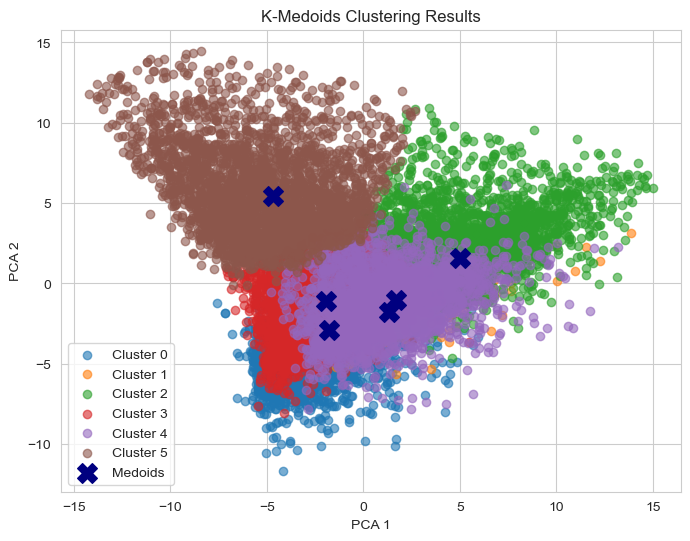

In [41]:
kmedioida_vizualization(X, labels_medioids, medoids_df, title='K-Medoids Clustering Results')

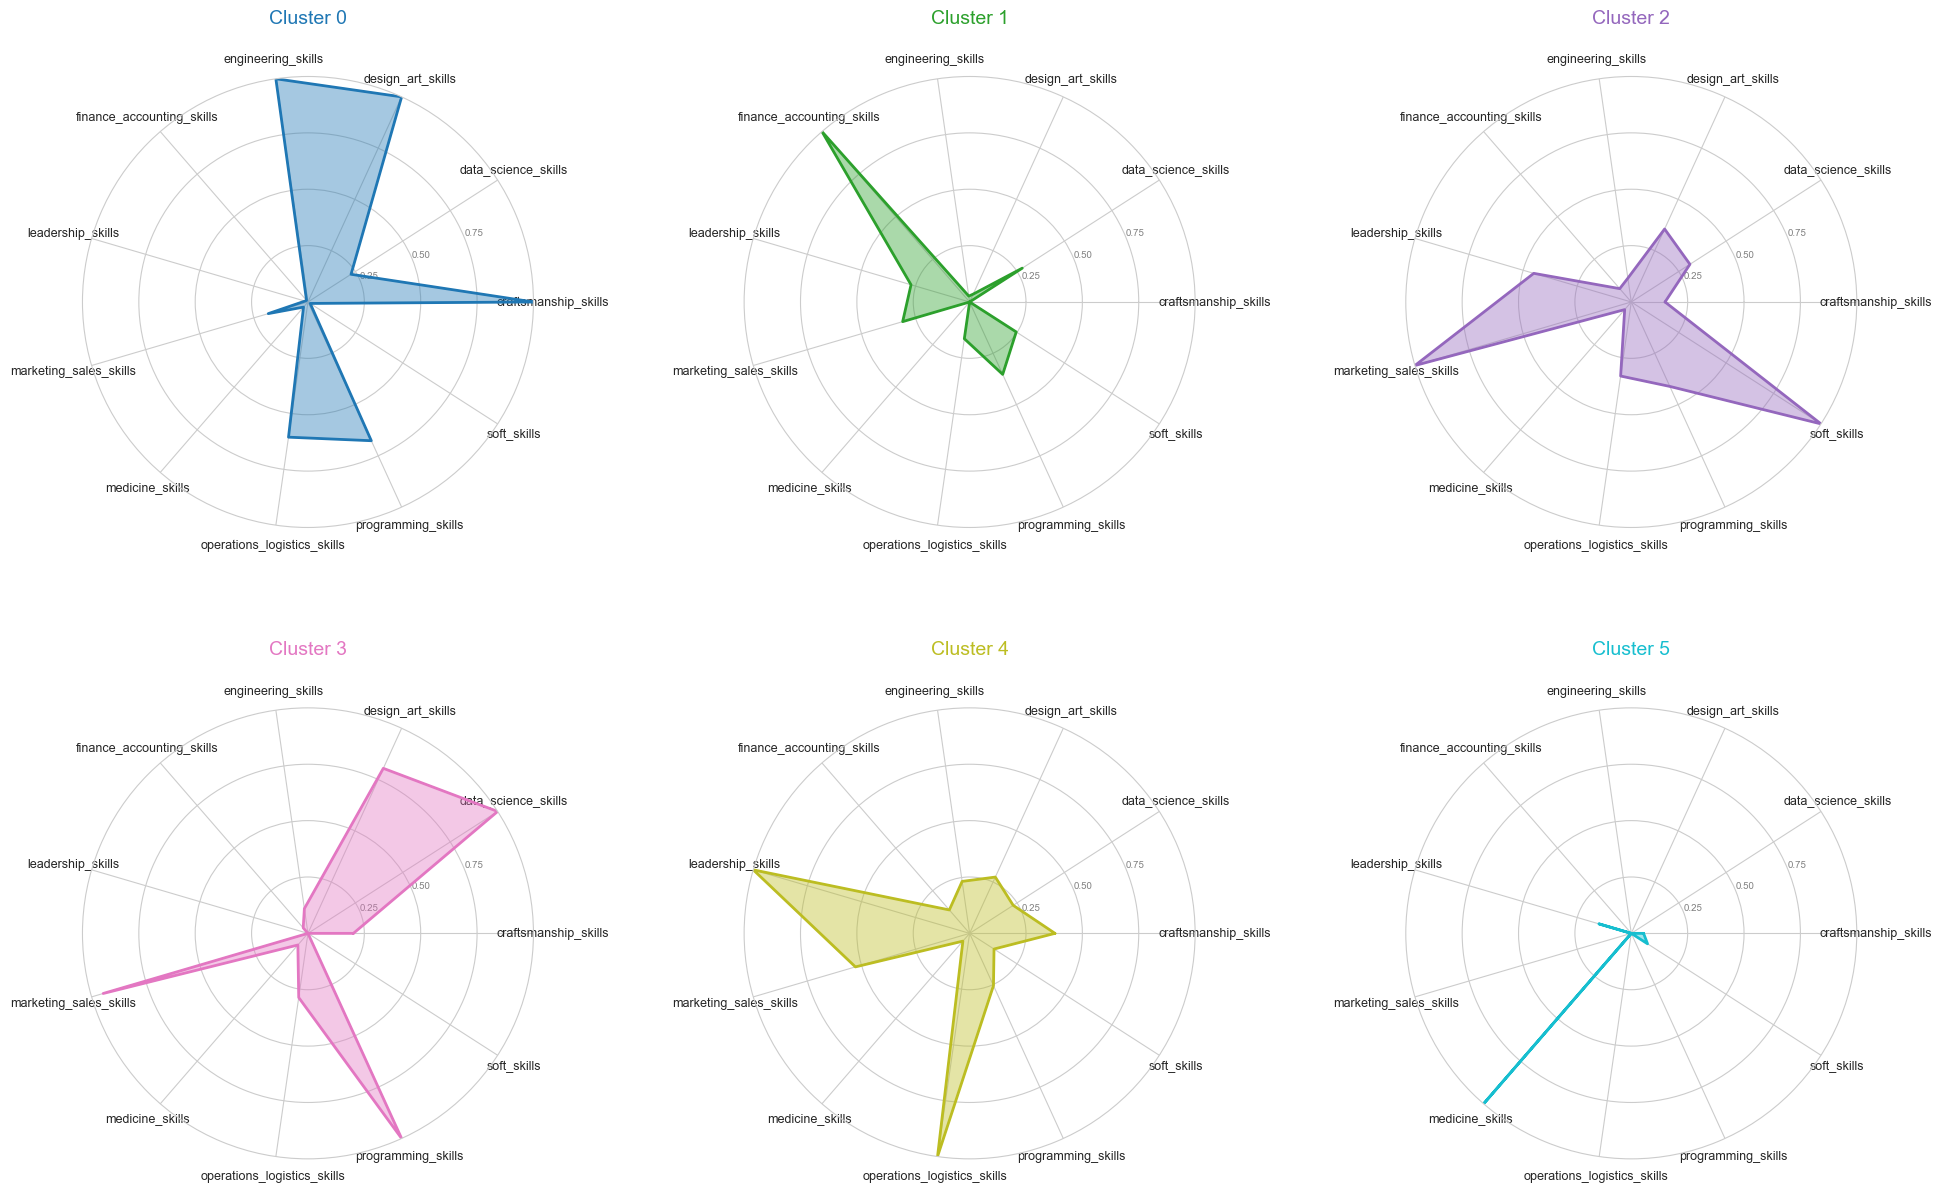

In [42]:
df_master2['Cluster_Medoids'] = labels_medioids
numeric_cols = df_master2.select_dtypes(include=[np.number]).columns.drop(['Cluster', 'Cluster_Medoids'], errors='ignore')
cluster_means_medoids = df_master2.groupby('Cluster_Medoids')[numeric_cols].mean()
scaler = MinMaxScaler()

df_scaled1 = pd.DataFrame(scaler.fit_transform(cluster_means_medoids), 
                         columns=cluster_means_medoids.columns, 
                         index=cluster_means_medoids.index)

colors = plt.cm.get_cmap("tab10", len(df_scaled1))

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12), subplot_kw=dict(polar=True))
axes = axes.flatten() 

for i, cluster_id in enumerate(df_scaled1.index):
    make_spider_plot(
        df=df_scaled1, 
        row=cluster_id, 
        title=f"Cluster {cluster_id}", 
        ax=axes[i], 
        color=colors(i)
    )



for j in range(len(df_scaled1), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.subplots_adjust(hspace=0.4) 
plt.show()



**Clusters characteristics**

***

* **Cluster 0** : The Industrial Technologist

**Dominant skills**: Engineering, Craftsmanship, Programming

*Example positions*: Robotics Engineer/ Manufacturing Engineer/ Embedded Systems Developer/ R&D Specialist

Comparing to the first cliustering results, this group combines digital skills (coding/data) with physical engineering and craftsmanship, not pure IT roles.

***

* **Cluster 1** : The Banking Backbone

*Dominant skills* : Finance and Accounting skills, Operations and Logistics skills

*Example positions*: Accountant/ Financial analysyst/ Supply Chain Manager/ Business analyst

This is cluster cleary made of corparate job - probably mostly in banking and finance. This match of financial skills and operational/logistics skills also, in my opnion, makes a good pair.

***

* **Cluster 2**: The Creative and Commercial Role

*Dominant Skills*: Marketing Soft skills

*Example positions*: Marketing Manager / Brand Director/ Creative Director/ Product Owner/ Sales Team Leader 

Within these clusters are more of a creative driven roles with an ability to work with the clinet (soft skills)

***


* **Cluster 3**: The Digital Innovator

*Dominant Skills*: Marketing,Sales, Design, Art and Data Science skills

*Exmaple positions*: Data Scientist / ML Engineer/ Full Stack Developer/ UI/UX Designer/ Frontend Developer

Roles focused on brand growth, customer engagement. Probably data science and analysis used in commerce and marketing. Previously the datasciece skills where put more in the typiccly tech jobs clister, now it is combined with marketing and sales which is also very popular usage of data driven solutions.

***

* **Cluster 4**: The Leader & People Manager

*Dominant skills*: Leadership skills, Soft sills, Operational skills

*Exmaple positions*: Project Manager/ Scrum Master/ HR Manager/ Recruiter/ Team Leader/ Office Manager 

This is classical set of skills for people working in managment - abilities to stair the team into the right direction

***

* **Cluster 5**: Medical Field expert

*Dominant skills*: Medical skills

*Example positions*: Registered nurse/ CTS practitioner/ phisotherapist/ gynecologist

Withing this clusters we have jobs with only medical skills listed, and a small amount of soft skills. As we can see on K-means clustering visualization, this cluster is the biggest - which is supported by EDA results

***

**Summary**

These cluistering resembles the previous one but in my opnion it is a little bit less inuite. The clusters layer on top of each other more, and the distiction is less visible.

***

**Evaluation of clustering**







In [43]:
clustering_metrics(X, labels_medioids)

Metric      Value
0         Silhouette Score     0.1782
1     Davies-Bouldin Index     1.6715
2  Calinski-Harabasz Index  3092.5804

*** 

## Summary of clustering

Our exploration of the job market through clustering algorithms has highlighted clear divisions between 'Hard Tech', 'Soft Management', and 'Specialized Operations'. We tested multiple approaches to find the best fit for our high-dimensional data.

While K-Medoids helped us identify specific "exemplar" job offers, the K-Means algorithm offered superior stability and ease of interpretation regarding the average skill distribution within groups. To ensure consistent and actionable insights in the next steps of our analysis, **we have selected K-Means as our final model**.
